# 2023 Immune dataset H3K4me3 vs RNA-seq

Benchmark according to the paper https://doi.org/10.1093/bib/bbw035
Features that define the best ChIP-seq peak calling algorithms

We considered a peak as positive if it overlaps an active gene (defined varying RPKM from 0 to 2)
and compared methods based on sensitivity, precision and F-score.

Data:
https://www.encodeproject.org/immune-cells/?type=Experiment&replicates.library.biosample.donor.organism.scientific_name=Homo+sapiens&biosample_ontology.cell_slims=hematopoietic+cell&biosample_ontology.classification=primary+cell&control_type!=*&status!=replaced&status!=revoked&status!=archived&biosample_ontology.system_slims=immune+system&biosample_ontology.system_slims=circulatory+system&config=immune

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

%config InlineBackend.figure_format='retina'

from IPython.display import display
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns

sns.set_style("whitegrid")

import numpy as np
import os

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

In [3]:
PATH = os.path.expanduser('~/data/2023_Immune')
# PATH = os.path.expanduser('~/data/2023_Immune_no_control')

! mkdir -p {PATH}/pics

## Load hg38 gtf file

In [4]:
gtf_df = pd.read_csv(os.path.expanduser(
    '~/data/2023_Immune/gencode.GRCh38.p13.v41.annotation.gtf'),
    sep='\t', comment='#',
    names=['chromosome', 'db', 'type', 'start', 'end', 'point1', 'strand', 'point2', 'aux'])
gtf_df.sample(10)

chromosome      db         type      start        end point1 strand  \
3193265      chr22  HAVANA   stop_codon   23059462   23059464      .      -   
2269780      chr14  HAVANA         exon   50739308   50739487      .      -   
3099318      chr20  HAVANA          CDS   35690413   35690565      .      -   
1413517       chr8  HAVANA   transcript   16374618   16375082      .      +   
3294208       chrX  HAVANA          CDS   53201550   53201744      .      -   
931689        chr5  HAVANA  start_codon    1882645    1882647      .      -   
1547243       chr9  HAVANA          CDS   34657035   34657149      .      +   
1066543       chr5  HAVANA         exon  176352622  176352748      .      -   
1400906       chr7  HAVANA         exon  157337025  157337144      .      +   
1269029       chr7  HAVANA          CDS   30662694   30662847      .      -   

        point2                                                aux  
3193265      0  gene_id "ENSG00000100218.12"; transcript_id "E...  
2269780      .  gene_id "ENSG00000100503.26"; transcript_id "E...  
3099318      0  gene_id "ENSG00000244005.13"; transcript_id "E...  
1413517      .  gene_id "ENSG00000253934.2"; transcript_id "EN...  
3294208      0  gene_id "ENSG00000126012.13"; transcript_id "E...  
931689       0  gene_id "ENSG00000113430.10"; transcript_id "E...  
1547243      2  gene_id "ENSG00000137070.19"; transcript_id "E...  
1066543      .  gene_id "ENSG00000122203.15"; transcript_id "E...  
1400906      .  gene_id "ENSG00000105993.15"; transcript_id "E...  
1269029      0  gene_id "ENSG00000106113.19"; transcript_id "E...

In [5]:
import re

print('Parse GTF aux data')
auxes = {}
for i, aux in enumerate(tqdm(gtf_df['aux'])):
    for pair in aux.split(';'):
        kv = pair.strip().split(' ')
        if len(kv) != 2:
            continue
        k, v = kv
        if k not in auxes:
            auxes[k] = vs = []
        else:
            vs = auxes[k]
        vs.append(v.strip('"'))

for k, vs in auxes.items():
    if len(vs) == len(gtf_df):
        gtf_df[k] = vs
    else:
        print(f'Ignoring {k}')
del auxes
gtf_df.drop('aux', axis=1, inplace=True)

# Fix . in gene_id
gtf_df['gene_id'] = [re.sub('\..*', '', id) for id in gtf_df['gene_id']]

Parse GTF aux data


  0%|          | 0/3375759 [00:00<?, ?it/s]

Ignoring hgnc_id
Ignoring havana_gene
Ignoring transcript_id
Ignoring transcript_type
Ignoring transcript_name
Ignoring transcript_support_level
Ignoring tag
Ignoring havana_transcript
Ignoring exon_number
Ignoring exon_id
Ignoring ont
Ignoring protein_id
Ignoring ccdsid
Ignoring artif_dupl


In [6]:
print(f'Total hg38 records {len(gtf_df)}')
print(f'Total hg38 genes {sum(gtf_df["type"] == "gene")}')
print(f'Total hg38 protein_coding genes {sum((gtf_df["type"] == "gene") & (gtf_df["gene_type"] == "protein_coding"))}')

gtf_genes_df = gtf_df[gtf_df['type'] == 'gene']
gtf_genes_df.sample(5)

Total hg38 records 3375759
Total hg38 genes 61852
Total hg38 protein_coding genes 20017


chromosome       db  type      start        end point1 strand point2  \
3303034       chrX   HAVANA  gene   67791955   67792895      .      -      .   
137234        chr1  ENSEMBL  gene   86357632   86357687      .      -      .   
1962478      chr11   HAVANA  gene  118510273  118531094      .      -      .   
1389439       chr7  ENSEMBL  gene  148876018  148876286      .      +      .   
1932389      chr11   HAVANA  gene   88061774   88098147      .      -      .   

                 gene_id             gene_type        gene_name level  
3303034  ENSG00000234201  processed_pseudogene           BMI1P1     1  
137234   ENSG00000278281                 miRNA          MIR7856     3  
1962478  ENSG00000255435                lncRNA        TTC36-AS1     2  
1389439  ENSG00000275586              misc_RNA      Metazoa_SRP     3  
1932389  ENSG00000255102                lncRNA  ENSG00000255102     2

## Annotate RNA-seq tables with TSS positions

In [7]:
def merge_genes(full_df):
    print('Merging overlapping regions', len(full_df))
    ts = []
    for chr in full_df['chromosome'].unique():
        t = full_df[full_df['chromosome'] == chr].sort_values(by=['start', 'end']).copy()
        cols = t.columns.difference(['start', 'end'])
        grps = t['start'].sub(t['end'].shift()).gt(1).cumsum()
        gpby = t.groupby(grps)
        t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
        t['chromosome'] = chr
        t['gene_id'] = 'merged'
        t['strand'] = '.'
        t = t[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']]
        ts.append(t)
    ts = pd.concat(ts).reset_index(drop=True)
    print('Reduced to', len(ts))
    return ts

In [8]:
import re

EXPRESSION_TSV = {
    'BCell': PATH + '/expression/BCell_RNAseq_hg38_ENCFF947SKG.tsv',
    'TCell': PATH + '/expression/TCell_RNAseq_hg38_ENCFF502AZI.tsv',
    'Monocyte': PATH + '/expression/Monocyte_RNAseq_hg38_ENCFF408GAO.tsv',
}

EXPRESSION_TSS_BED = {}
THRESHOLD = 0.1
TSS = 500

for cell, path in EXPRESSION_TSV.items():
    print(cell, path)
    t = pd.read_csv(path, sep='\t')
    # Fix . in gene_id
    t['gene_id'] = [re.sub('\..*', '', id) for id in t['gene_id']]
    t['LTPM'] = np.log1p(t['TPM'])

    # Plot expression
    # plt.figure(figsize=(10, 1))
    # ax = plt.axes()
    # g_results = sns.histplot(data=t, x='LTPM', ax=ax,
    #                          stat='density',
    #                          bins=50, kde=True, alpha=0.4)
    # ax.title.set_text(f'{cell} expression')
    # plt.show()

    # Save expressed genes
    full_df = pd.merge(left=t, right=gtf_genes_df, left_on='gene_id', right_on='gene_id')
    print(f'Total genes with positions {len(full_df)}')
    full_df = full_df[full_df['LTPM'] > THRESHOLD]
    print(f'Genes logTPM > {THRESHOLD} {len(full_df)}')

    starts = [
        max(1, start - TSS if strand == '+' else end - TSS)
        for start, end, strand in zip(full_df['start'], full_df['end'], full_df['strand'])
    ]
    ends = [
        start + TSS if strand == '+' else end + TSS
        for start, end, strand in zip(full_df['start'], full_df['end'], full_df['strand'])
    ]
    full_df['start'] = starts
    full_df['end'] = ends
    full_df.sort_values(by=['chromosome', 'start'], inplace=True)
    full_df = merge_genes(full_df[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']])

    expr_path = path.replace('.tsv', f'_tpm{THRESHOLD}_tss{TSS}.bed')
    full_df.to_csv(expr_path, sep='\t', index=False, header=None)
    print(f'Saved expressed genes fom {cell} to {expr_path}')
    EXPRESSION_TSS_BED[cell] = expr_path


BCell /home/jetbrains/data/2023_Immune/expression/BCell_RNAseq_hg38_ENCFF947SKG.tsv
Total genes with positions 58387
Genes logTPM > 0.1 20769
Merging overlapping regions 20769
Reduced to 18107
Saved expressed genes fom BCell to /home/jetbrains/data/2023_Immune/expression/BCell_RNAseq_hg38_ENCFF947SKG_tpm0.1_tss500.bed
TCell /home/jetbrains/data/2023_Immune/expression/TCell_RNAseq_hg38_ENCFF502AZI.tsv
Total genes with positions 58387
Genes logTPM > 0.1 21110
Merging overlapping regions 21110
Reduced to 18413
Saved expressed genes fom TCell to /home/jetbrains/data/2023_Immune/expression/TCell_RNAseq_hg38_ENCFF502AZI_tpm0.1_tss500.bed
Monocyte /home/jetbrains/data/2023_Immune/expression/Monocyte_RNAseq_hg38_ENCFF408GAO.tsv
Total genes with positions 58387
Genes logTPM > 0.1 18584
Merging overlapping regions 18584
Reduced to 16146
Saved expressed genes fom Monocyte to /home/jetbrains/data/2023_Immune/expression/Monocyte_RNAseq_hg38_ENCFF408GAO_tpm0.1_tss500.bed


## Load peaks

In [5]:
IMMUNE_CELLS = ['BCell', 'TCell', 'Monocyte']
MODIFICATIONS = ['H3K4me3']


def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in IMMUNE_CELLS if cc in f), None)
        mod = next((m for m in MODIFICATIONS if m in f), None)
        # print(f, fdr, cell, mod)
        if fdr and cell and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (peaks_path, mod, cell, fdr, ps, avls)
    return df_fdr

In [6]:
df_fdr_macs2 = load_peaks_fdr(os.path.join(PATH, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(PATH, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(PATH, 'sicer'), 'summary-FDR', ['0.01'])
# df_fdr_sicer = load_peaks_fdr(os.path.join(PATH, 'sicer'), 'scoreisland', ['0.01'])
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))

df_fdr_span = load_peaks_fdr(os.path.join(PATH, 'span'), '.peak', ['0.05'])
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

df_fdr_peaks = pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks.sample(5)

  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 3


  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 broad 3


  0%|          | 0/118 [00:00<?, ?it/s]

SICER 3


  0%|          | 0/17 [00:00<?, ?it/s]

SPAN 3


file modification      cell  \
2  /home/jetbrains/data/2023_Immune/sicer/BCell_H...      H3K4me3     BCell   
0  /home/jetbrains/data/2023_Immune/macs2/Monocyt...      H3K4me3  Monocyte   
0  /home/jetbrains/data/2023_Immune/macs2/Monocyt...      H3K4me3  Monocyte   
0  /home/jetbrains/data/2023_Immune/sicer/TCell_H...      H3K4me3     TCell   
2  /home/jetbrains/data/2023_Immune/span/TCell_H3...      H3K4me3     TCell   

    fdr  peaks     avlength         tool  
2  0.01  18342  2621.462109        SICER  
0  0.05  26555   996.763623        MACS2  
0   0.1  24096  1148.390978  MACS2 broad  
0  0.01  21785  2442.736516        SICER  
2  0.05  25006  1518.703391         SPAN

In [7]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER', 'Genes']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

## Peaks number and lengths

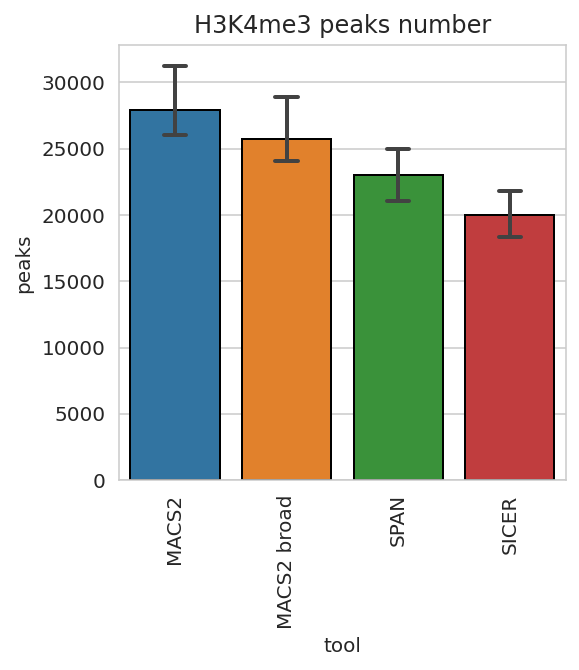

In [12]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_fdr_peaks, x='tool', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('H3K4me3 peaks number')
plt.show()

In [13]:
ts = []
for file, tool in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(name=[tool] * len(lengths), length=lengths))
    ts.append(t.sample(min(len(t), 10_000)))
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

0it [00:00, ?it/s]

name  length
44882   MACS2 broad     358
47114   MACS2 broad     452
30498   MACS2 broad     327
25164         MACS2     686
69710         SICER     999
30735   MACS2 broad     239
6760          MACS2     491
90621          SPAN     796
77432         SICER    1799
105439         SPAN     688

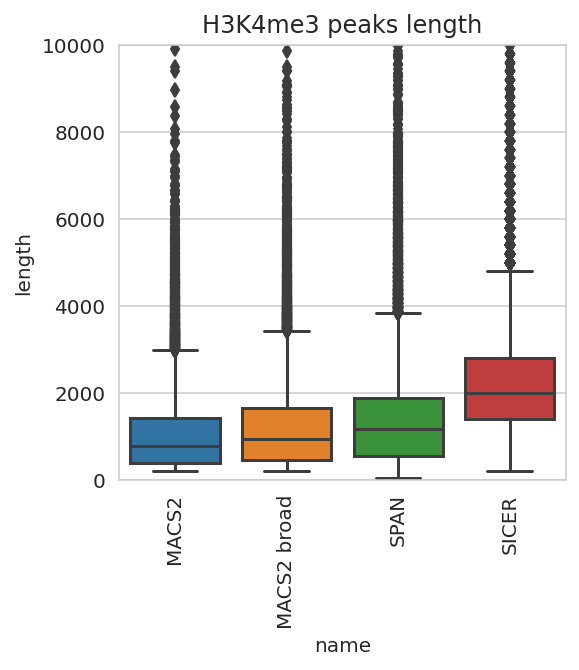

In [14]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.boxplot(data=t, x='name', y='length', ax=ax,
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax.title.set_text('H3K4me3 peaks length')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim([0, 10_000])
plt.show()

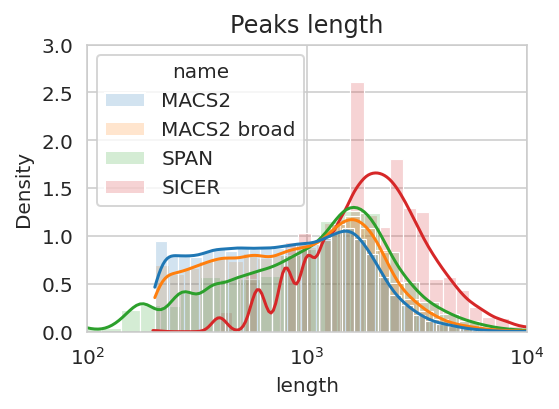

In [15]:
plt.figure(figsize=(4, 3))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='name', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=35, kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE,
                         hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
g_results.set(xscale='log')
g_results.set_ylim(0, 3)
g_results.set_xlim(1e2, 1e4)
ax.title.set_text('Peaks length')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_lengths.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [16]:
# # Randomly tweak SPAN, SICER lengths for visualization purposes
# tsicer = t['name'] == 'SICER'
# t.loc[tsicer, 'length'] += np.random.normal(0, 100, size=sum(tsicer))
# tspan = t['name'] == 'SPAN'
# t.loc[tspan, 'length'] += np.random.normal(0, 100, size=sum(tspan))

In [17]:
# plt.figure(figsize=(8, 5))
# ax = plt.axes()
# g_results = sns.histplot(data=t, x='length', hue='name', ax=ax,
#                          stat='density', common_bins=False, common_norm=False,
#                          bins=200, kde=True, log_scale=True, alpha=0.2,
#                          palette=TOOLS_PALETTE)
# g_results.set(xscale='log')
# g_results.set_ylim(0, 3)
# g_results.set_xlim(1e2, 1e4)
# ax.title.set_text('H3K4me3 peaks length')
# plt.show()

In [18]:
t = []
for file, tool in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    coverage = bedl(file).sum()
    t.append((tool, coverage))
t = pd.DataFrame(data=t, columns=['tool', 'coverage'])
t.sample(10)

0it [00:00, ?it/s]

tool  coverage
7         SICER  40911445
1         MACS2  33096533
5   MACS2 broad  35746467
9          SPAN  28873968
2         MACS2  27199758
4   MACS2 broad  28781483
11         SPAN  37976697
10         SPAN  31277416
3   MACS2 broad  27671629
0         MACS2  26469058

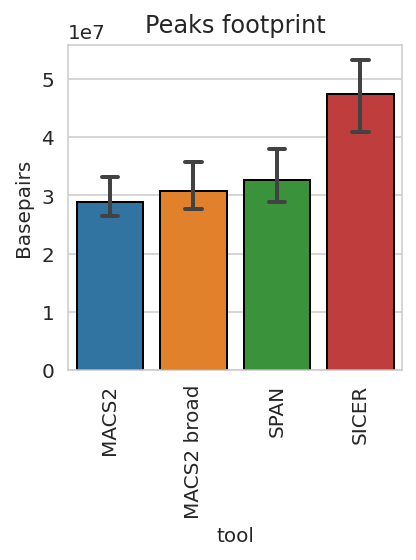

In [19]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
g_results = sns.barplot(data=t, x='tool', y='coverage', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('Peaks footprint')
ax.set_ylabel('Basepairs')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_sumlength.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Overlap H3K4me3 vs expressed genes TSS

In [20]:
import tempfile
from itertools import product

tf = tempfile.mktemp()

bench_df = pd.DataFrame(
    columns=['cell', 'name',
             'peaks', 'peaks_len', 'tss', 'tss_len',
             'peaks_overlap', 'peaks_overlap_len', 'tss_overlap', 'tss_overlap_len'],
    dtype=object
)

for c in tqdm(IMMUNE_CELLS):
    print(c)
    tss_file = sorted_file(EXPRESSION_TSS_BED[c])
    tss = lines(tss_file)
    tss_len = int(bedl(tss_file).sum())
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        peaks_len = int(bedl(peaks_file).sum())
        !bedtools intersect -a {peaks_file} -b {tss_file} -wa -u > {tf}
        peaks_overlap = lines(tf)
        !bedtools intersect -b {peaks_file} -a {tss_file} -wa -u > {tf}
        tss_overlap = lines(tf)
        !bedtools intersect -a {peaks_file} -b {tss_file} -wo > {tf}
        peaks_overlap_len = tss_overlap_len = int(last_col(tf).sum())

        bench_df.loc[len(bench_df)] = (c, tool, peaks, peaks_len, tss, tss_len,
                                       peaks_overlap, peaks_overlap_len, tss_overlap, tss_overlap_len)
# bench_df

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


In [21]:
bench_df['precision'] = [d(a, b) for a, b in zip(bench_df['peaks_overlap'], bench_df['peaks'])]
bench_df['sensitivity'] = [d(a, b) for a, b in zip(bench_df['tss_overlap'], bench_df['tss'])]
bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                  for s, p in zip(bench_df['sensitivity'], bench_df['precision'])]
bench_df['precision_len'] = [d(a, b) for a, b in zip(bench_df['peaks_overlap_len'], bench_df['peaks_len'])]
bench_df['sensitivity_len'] = [d(a, b) for a, b in zip(bench_df['tss_overlap_len'], bench_df['tss_len'])]
bench_df['f1_len'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                      for s, p in zip(bench_df['sensitivity_len'], bench_df['precision_len'])]

bench_df['jaccard'] = [
    d(o, p + g - o)
    for p, g, o in zip(bench_df['peaks_len'], bench_df['tss_len'], bench_df['tss_overlap_len'])
]

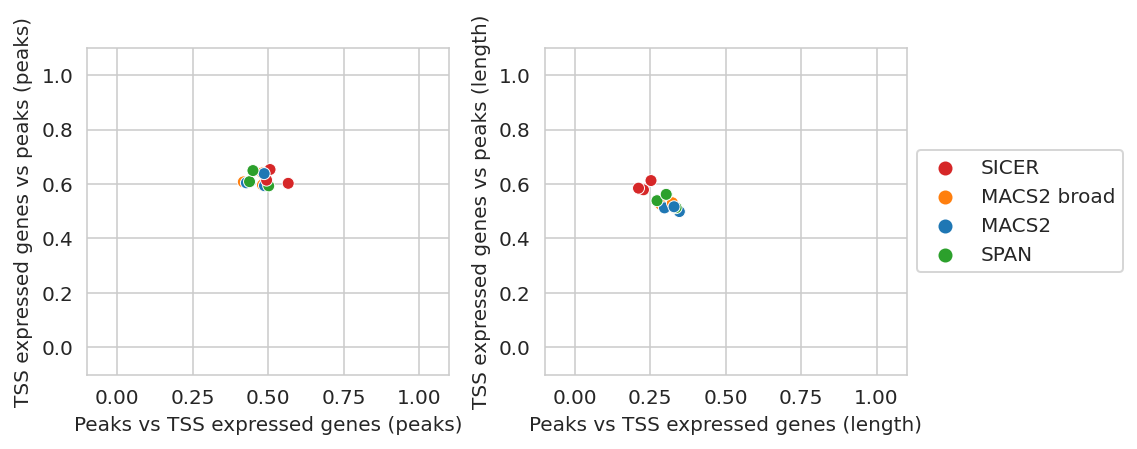

In [22]:
import seaborn as sns

plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

ax = axs[0]
g_results = sns.scatterplot(data=bench_df, x='precision', y='sensitivity', hue='name',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.set_xlabel('Peaks vs TSS expressed genes (peaks)')
g_results.axes.set_ylabel('TSS expressed genes vs peaks (peaks)')
g_results.axes.set_xlim([-0.1, 1.1])
g_results.axes.set_ylim([-0.1, 1.1])
ax.legend().set_visible(False)

ax = axs[1]
g_results = sns.scatterplot(data=bench_df, x='precision_len', y='sensitivity_len', hue='name',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.set_xlabel('Peaks vs TSS expressed genes (length)')
g_results.axes.set_ylabel('TSS expressed genes vs peaks (length)')
g_results.axes.set_xlim([-0.1, 1.1])
g_results.axes.set_ylim([-0.1, 1.1])
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [23]:
ts = []
for name in bench_df['name'].unique():
    tn = bench_df[bench_df['name'] == name]
    for variable in ['sensitivity', 'precision', 'f1']:
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['peak'] * len(tn),
                                    value=tn[variable])))
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['length'] * len(tn),
                                    value=tn[f'{variable}_len'])))

t = pd.concat(ts).reset_index(drop=True)
del ts

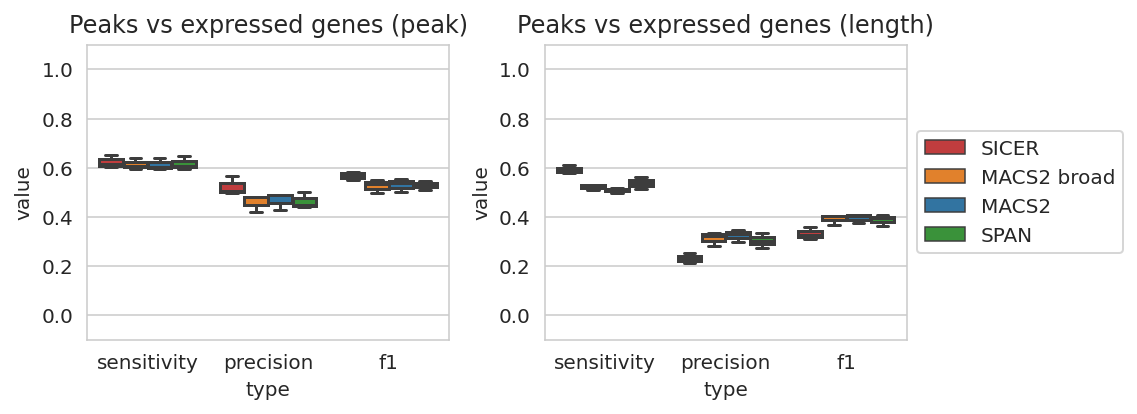

In [24]:
plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, benchmark in enumerate(['peak', 'length']):
    g_results = sns.boxplot(data=t[t['benchmark'] == benchmark], x='type', y='value', hue='name', palette=TOOLS_PALETTE,
                            ax=axs[i])
    ax = g_results.axes
    ax.set_title(f'Peaks vs expressed genes ({benchmark})')
    # Put a legend to the right of the current axis
    if i == 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    ax.set_ylim([-0.1, 1.1])

plt.tight_layout()
plt.show()

## Overlap H3K4me3 diff vs expressed genes TSS

In [25]:
TOOLS = list(sorted(set(bench_df['name'])))

diff_bench_df = pd.DataFrame(
    columns=['cell', 'name',
             'peaks', 'peaks_len',
             'tss', 'tss_len',
             'peaks_overlap', 'peaks_overlap_len',
             'tss_overlap', 'tss_overlap_len'],
    dtype=object
)

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

for c in tqdm(IMMUNE_CELLS):
    if (c) not in EXPRESSION_TSS_BED:
        continue
    print(c)
    tss_file = sorted_file(EXPRESSION_TSS_BED[c])
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == 'SPAN') &
                     (df_fdr_peaks['modification'] == 'H3K4me3') &
                     (df_fdr_peaks['cell'] == c)]
    if len(t) == 0:
        continue
    span_file = sorted_file(t['file'].values[0])
    tss = lines(tss_file)
    tss_len = int(bedl(tss_file).sum())
    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            peaks_len = int(bedl(tf).sum())
            !bedtools intersect -a {tf} -b {tss_file} -wa -u > {tf2}
            peaks_overlap = lines(tf2)
            !bedtools intersect -b {tf} -a {tss_file} -wa -u > {tf2}
            tss_overlap = lines(tf2)
            !bedtools intersect -a {tf} -b {tss_file} -wo > {tf2}
            peaks_overlap_len = tss_overlap_len = int(last_col(tf2).sum())

            diff_bench_df.loc[len(diff_bench_df)] = \
                (c, name,
                 peaks, peaks_len,
                 tss, tss_len,
                 peaks_overlap, peaks_overlap_len,
                 tss_overlap, tss_overlap_len)

display(diff_bench_df.sample())

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


cell                name  peaks  peaks_len    tss   tss_len  \
15  Monocyte  MACS2 broad - SPAN     24       5609  16146  16853177   

    peaks_overlap  peaks_overlap_len  tss_overlap  tss_overlap_len  
15              2                466            2              466

In [26]:
diff_bench_df['precision'] = [d(a, b) for a, b in zip(diff_bench_df['peaks_overlap'], diff_bench_df['peaks'])]
diff_bench_df['sensitivity'] = [d(a, b) for a, b in zip(diff_bench_df['tss_overlap'], diff_bench_df['tss'])]
diff_bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                       for s, p in zip(diff_bench_df['sensitivity'], diff_bench_df['precision'])]

diff_bench_df['precision_len'] = [d(a, b) for a, b in
                                  zip(diff_bench_df['peaks_overlap_len'], diff_bench_df['peaks_len'])]
diff_bench_df['sensitivity_len'] = [d(a, b) for a, b in zip(diff_bench_df['tss_overlap_len'], diff_bench_df['tss_len'])]
diff_bench_df['f1_len'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                           for s, p in zip(diff_bench_df['sensitivity_len'], diff_bench_df['precision_len'])]

diff_bench_df['jaccard'] = [
    d(o, p + g - o)
    for p, g, o in zip(diff_bench_df['peaks_len'], diff_bench_df['tss_len'], diff_bench_df['tss_overlap_len'])
]

In [27]:
full_bench_df = pd.concat([bench_df, diff_bench_df]).reset_index(drop=True)
full_bench_df.sample(5)

cell          name  peaks  peaks_len    tss   tss_len  peaks_overlap  \
11  Monocyte          SPAN  23059   31277416  16146  16853177          10369   
0      BCell         SICER  18342   48082858  18107  18887856          10392   
4      TCell         SICER  21785   53215015  18413  19197767          10782   
8   Monocyte         SICER  19955   40911445  16146  16853177          10102   
29  Monocyte  SICER - SPAN     72     147728  16146  16853177              1   

    peaks_overlap_len  tss_overlap  tss_overlap_len  precision  sensitivity  \
11            9468847        10482          9468847   0.449673     0.649201   
0            10929121        10907         10929121   0.566569     0.602364   
4            11222667        11307         11222667   0.494928     0.614077   
8            10322581        10544         10322581   0.506239     0.653041   
29                623            1              623   0.013889     0.000062   

          f1  precision_len  sensitivity_len    f1_len   jaccard  
11  0.531322       0.302738         0.561843  0.393465  0.244915  
0   0.583918       0.227298         0.578632  0.326385  0.195018  
4   0.548102       0.210893         0.584582  0.309964  0.183407  
8   0.570345       0.252315         0.612501  0.357401  0.217583  
29  0.000123       0.004217         0.000037  0.000073  0.000037

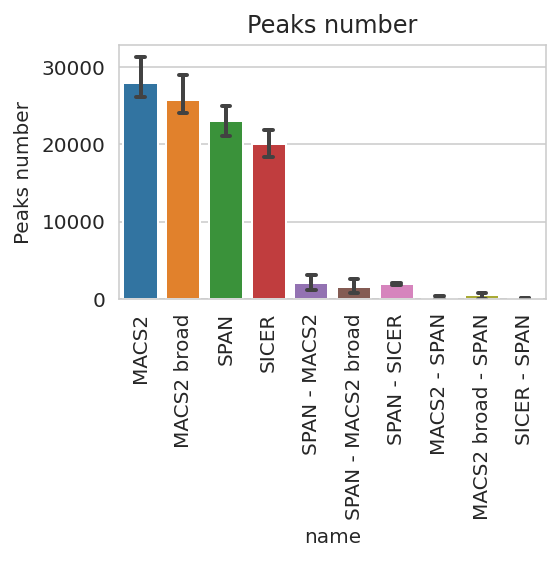

In [28]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Peaks number')
g_results = sns.barplot(data=full_bench_df, x='name', y='peaks',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad',  'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ]
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Peaks number')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Save benchmark

In [29]:
full_bench_df.to_csv(PATH + '/H3K4me3_full_bench_df.csv.gz', index=False, compression='gzip')

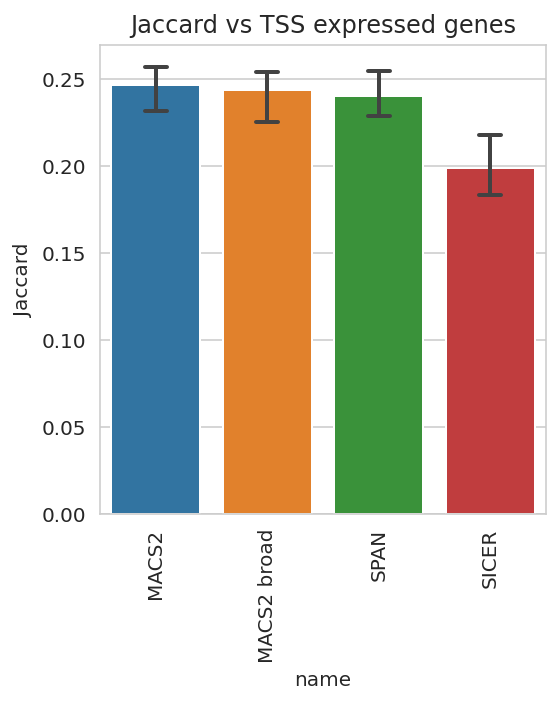

In [30]:
plt.figure(figsize=(4, 5))
ax = plt.axes()
ax.title.set_text('Jaccard vs TSS expressed genes')
g_results = sns.barplot(data=full_bench_df, x='name', y='jaccard',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Jaccard')
plt.tight_layout()
plt.show()

In [31]:
ts = []
for name in full_bench_df['name'].unique():
    tn = full_bench_df[full_bench_df['name'] == name]
    for variable in ['sensitivity', 'precision', 'f1']:
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['peak'] * len(tn),
                                    value=tn[variable])))
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['length'] * len(tn),
                                    value=tn[f'{variable}_len'])))
t = pd.concat(ts).reset_index(drop=True)
del ts

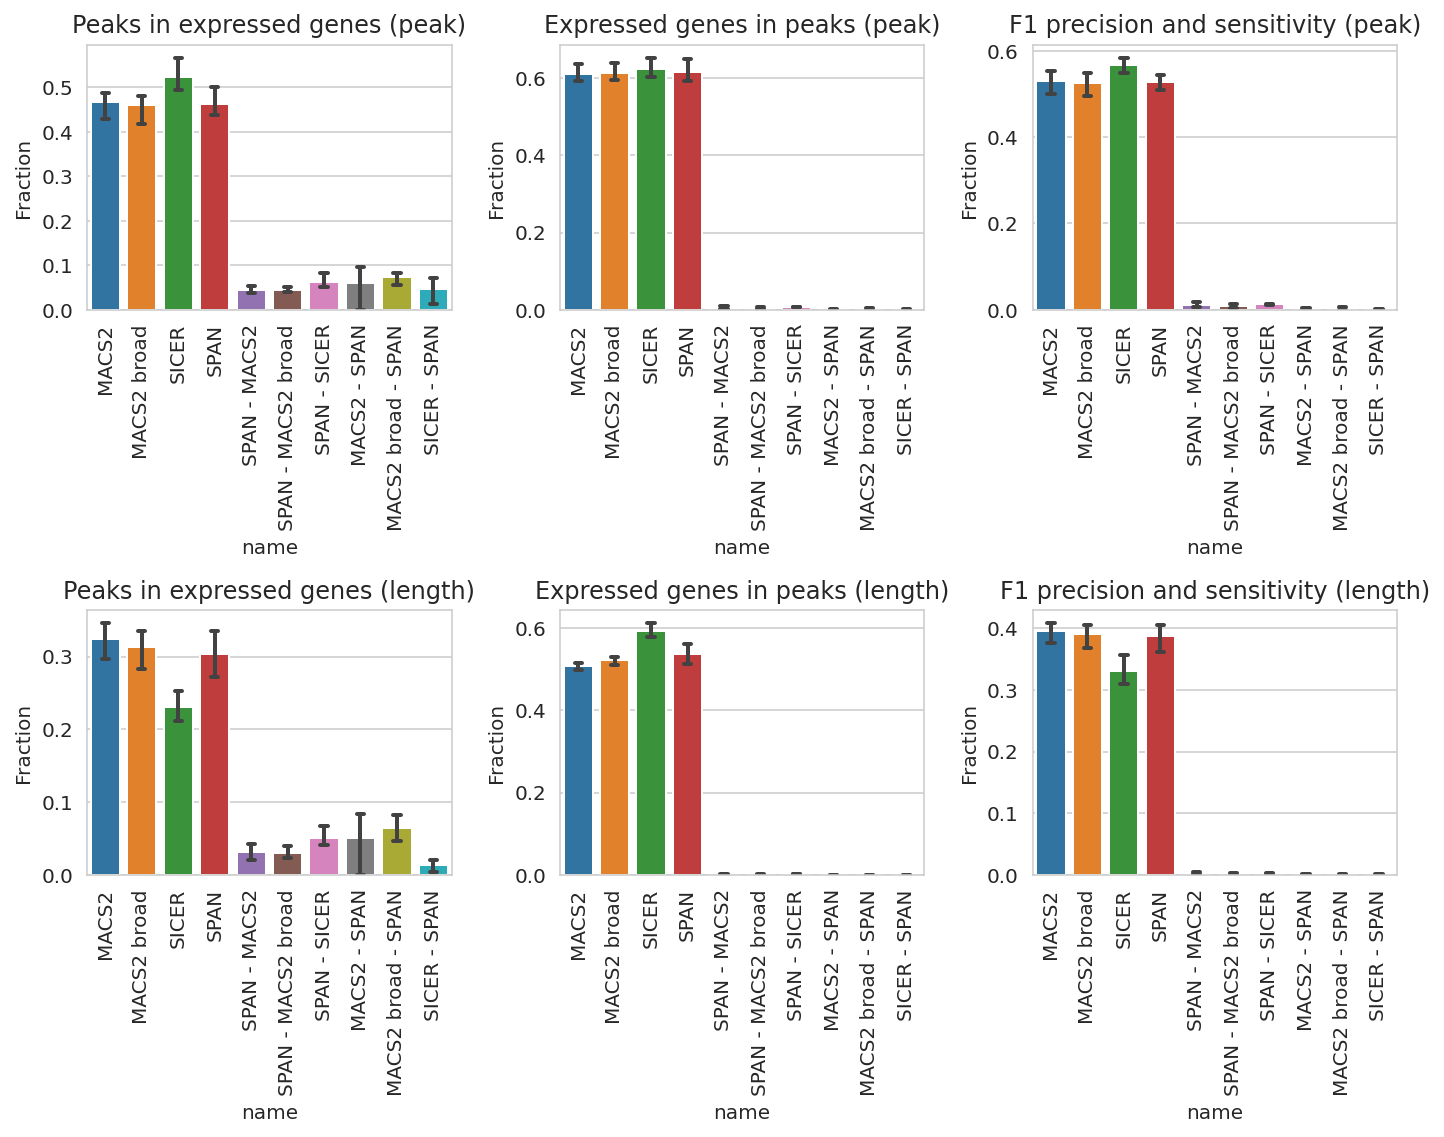

In [32]:
plt.figure(figsize=(10, 8))
axs = [plt.subplot(2, 3, i + 1) for i in range(6)]
for i, (benchmark, type) in enumerate(product(['peak', 'length'], ['precision', 'sensitivity', 'f1'])):
    ax = axs[i]
    if type == 'precision':
        ax.title.set_text(f'Peaks in expressed genes ({benchmark})')
    elif type == 'sensitivity':
        ax.title.set_text(f'Expressed genes in peaks ({benchmark})')
    else:
        ax.title.set_text(f'F1 precision and sensitivity ({benchmark})')
    sns.barplot(data=t[(t['benchmark'] == benchmark) & (t['type'] == type)], x='name', y='value',
                capsize=.2, errwidth=2, ax=ax,
                order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Fraction')
plt.tight_layout()
plt.show()

## Venn diagram

In [33]:
from matplotlib_venn import venn2, venn3


def num_format(x, engineer):
    if x <= 0:
        return ''
    elif engineer:
        return f'{x:.0e}'
    else:
        return str(x)

num_format(1.3e10, True)

VENN2_SUBSETS = ['1', '2', '1,2']
VENN2_LABELS = ['10', '01', '11']

def venn2_overlap(ax, peaks1, peaks2, overlap12, overlap21, name1, name2,
                  show_numbers=True, engineer=False, add_proportion=False,
                  set_font=15, subset_font=10):
    max_peaks = max(peaks1, peaks2)
    max_overlap = max(overlap12, overlap21)
    # Tweak subsets to avoid empty areas
    if show_numbers:
        subsets = (
            max(0.1 * max_peaks, min(0.9 * max_peaks, peaks1 - overlap12)) if peaks1 > overlap12 else 0,
            max(0.1 * max_peaks, min(0.9 * max_peaks, peaks2 - overlap21)) if peaks2 > overlap21 else 0,
            max(0.1 * max_peaks, min(0.9 * max_peaks, max_overlap))
        )
    else:
        subsets = (peaks1 - overlap12, peaks2 - overlap21, max_overlap)
    v = venn2(subsets=subsets, set_labels=(name1, name2), alpha=0.3, ax=ax)
    # venn2_circles(subsets=subsets, color='grey', ax=ax)

    if show_numbers:
        v.get_label_by_id('10').set_text(num_format(peaks1 - overlap12, engineer))
        v.get_label_by_id('01').set_text(num_format(peaks2 - overlap21, engineer))
        if add_proportion:
            if overlap12 != 0 and overlap21 != 0:
                if overlap12 > overlap21:
                    prop = f'{overlap12 / overlap21:.1f} : 1'
                else:
                    prop = f'1 : {overlap21 / overlap12:.1f}'
                prop = prop.replace('.0', '')  # Cosmetics
            else:
                prop = ''
            v.get_label_by_id('11').set_text(f'{overlap12} : {overlap21}\n{prop}')
        else:
            v.get_label_by_id('11').set_text(num_format(max_overlap, engineer))
    for text in v.set_labels:
        if text is not None:
            text.set_fontsize(set_font)
    for text in v.subset_labels:
        if text is not None:
            text.set_fontsize(subset_font)
    if not show_numbers:
        for l in VENN2_LABELS:
            label = v.get_label_by_id(l)
            if label is not None:
                label.set_text('')

VENN3_SUBSETS = ['1', '2', '1,2', '3', '1,3', '2,3', '1,2,3']
VENN3_LABELS = ['100', '010', '110', '001', '101', '011', '111']

def venn3_overlap(ax, v1, v2, v12, v3, v13, v23, v123, name1, name2, name3,
                  show_numbers=True, engineer=False,
                  set_font=15, subset_font=10):
    subsets=(v1, v2, v12, v3, v13, v23, v123)
    t = {l: s for l, s in zip(VENN3_LABELS, subsets)}
    v = venn3(subsets=subsets,
              set_labels=(name1, name2, name3),
              alpha=0.3,
              ax=ax)
    for text in v.set_labels:
        if text is not None:
            text.set_fontsize(set_font)
    for text in v.subset_labels:
        if text is not None:
            text.set_fontsize(subset_font)
    for l in VENN3_LABELS:
        label = v.get_label_by_id(l)
        if label is not None:
            if not show_numbers:
                label.set_text('')
            else:
                label.set_text(num_format(t[l], engineer))

  0%|          | 0/1 [00:00<?, ?it/s]

BCell
Venn diagrams of SPAN vs other tools (peaks)


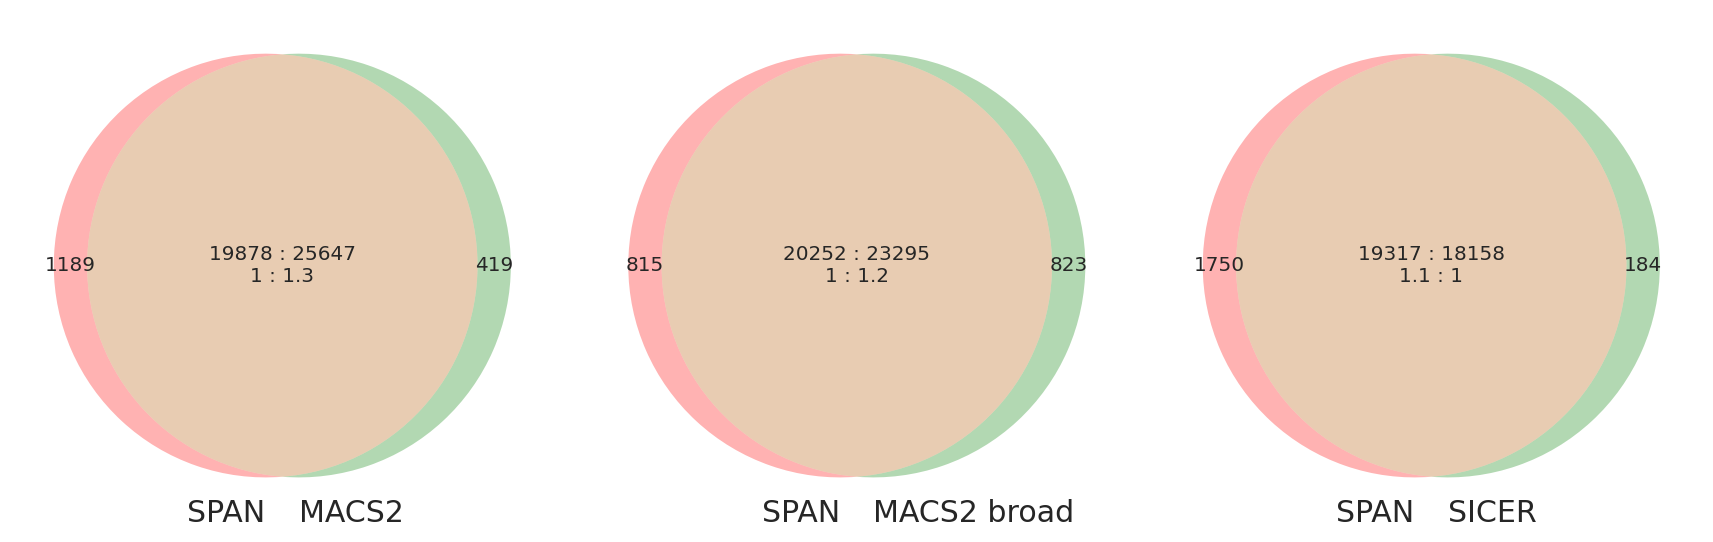

Venn diagram of SPAN vs other tools and TSS expressed genes (ranges)


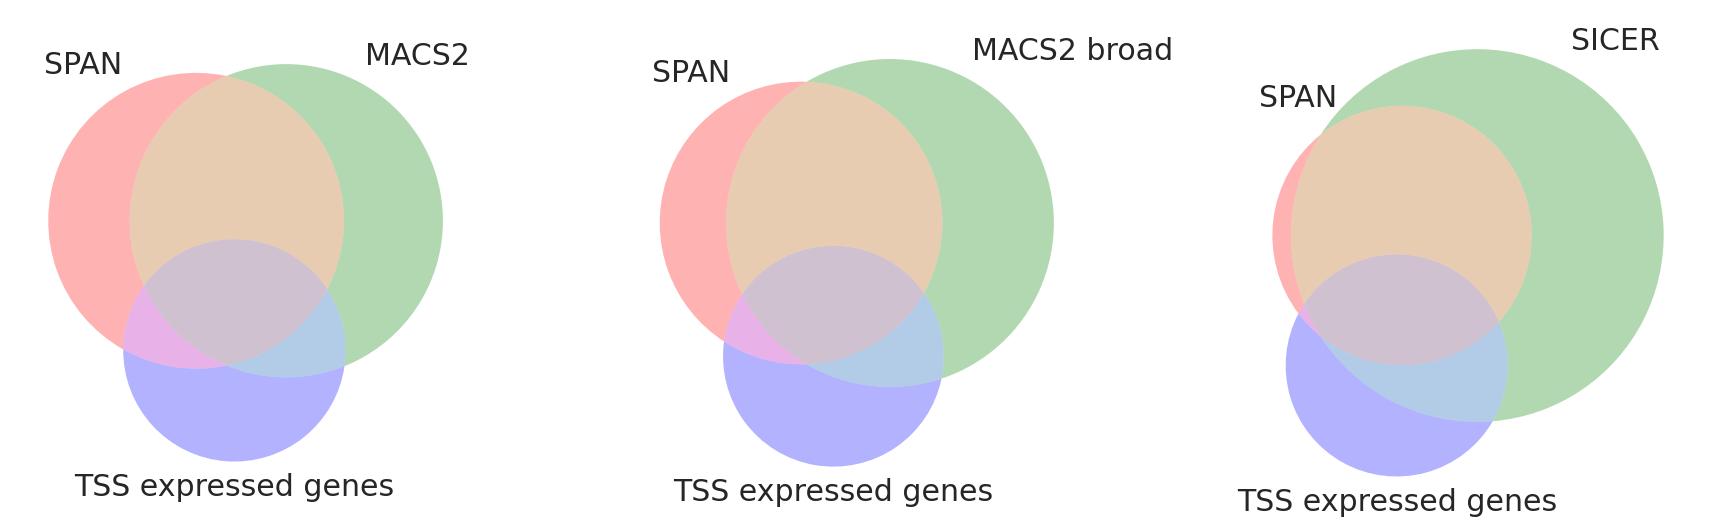

Venn diagram of SPAN vs other tools and TSS expressed genes (length)
Error: The requested file ({span_file}) could not be opened. Error message: (No such file or directory). Exiting!
Error: The requested file ({span_file}) could not be opened. Error message: (No such file or directory). Exiting!
Error: The requested file ({span_file}) could not be opened. Error message: (No such file or directory). Exiting!


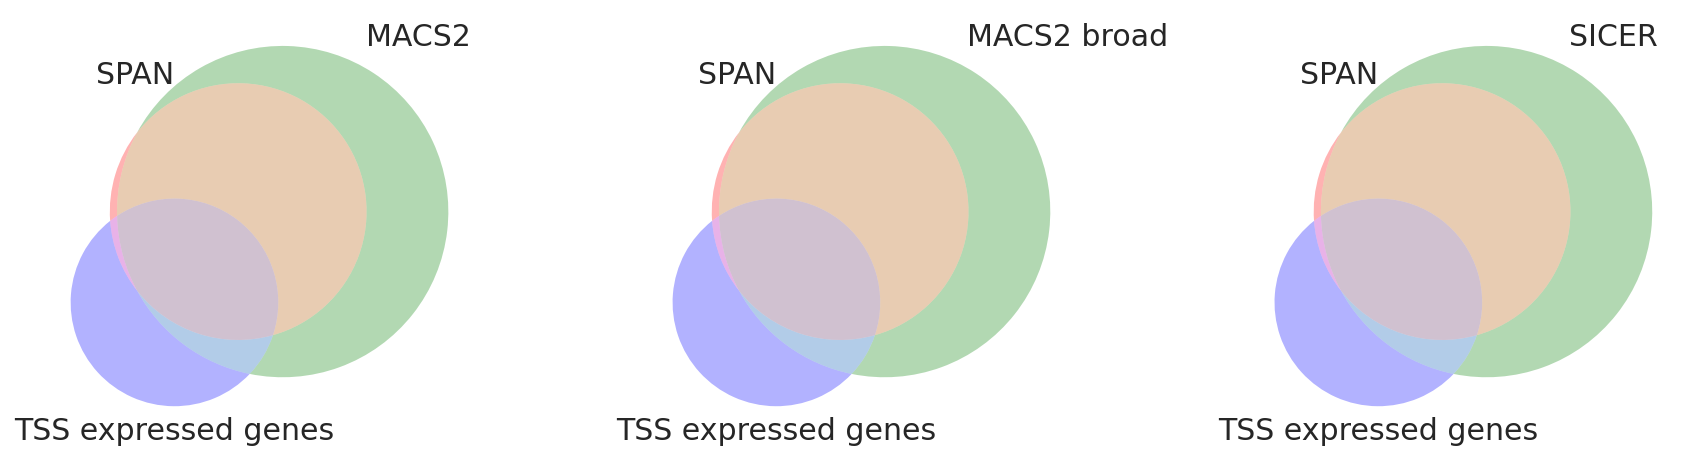

In [34]:
other_tools = list(sorted(filter(lambda t: t != 'SPAN', bench_df['name'].unique())))

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

for c in tqdm(['BCell']):
    if (c) not in EXPRESSION_TSS_BED:
        continue
    print(c)
    tss_file = sorted_file(EXPRESSION_TSS_BED[(c)])
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == 'SPAN') & (df_fdr_peaks['modification'] == 'H3K4me3') &
                     (df_fdr_peaks['cell'] == c)]
    if len(t) == 0:
        continue
    span_file = sorted_file(t['file'].values[0])
    span_peaks = lines(span_file)
    span_len = int(bedl(span_file).sum())
    tss_peaks = lines(tss_file)
    tss_length = int(bedl(tss_file).sum())

    print('Venn diagrams of SPAN vs other tools (peaks)')
    plt.figure(figsize=(4 * len(other_tools), 4))
    axs = [plt.subplot(1, len(other_tools), i + 1) for i in range(len(other_tools))]
    for i, tool in enumerate(other_tools):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks_number = lines(peaks_file)
        !bedtools intersect -a {span_file} -b {peaks_file} -wa -u > {tf}
        span_overlap = lines(tf)
        !bedtools intersect -b {span_file} -a {peaks_file} -wa -u > {tf}
        other_overlap = lines(tf)
        venn2_overlap(axs[i], span_peaks, peaks_number, span_overlap, other_overlap, 'SPAN', tool,
                      show_numbers=True, add_proportion=True)
    plt.tight_layout()
    # plt.savefig(f'{GSE26320_PATH}/analyze/venn_{m}.png', bbox_inches='tight', dpi=300)
    plt.show()

    print('Venn diagram of SPAN vs other tools and TSS expressed genes (ranges)')
    plt.figure(figsize=(4 * len(other_tools), 4))
    axs = [plt.subplot(1, len(other_tools), i + 1) for i in range(len(other_tools))]
    for i, tool in enumerate(other_tools):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks_number = lines(peaks_file)
        peaks_len = int(bedl(peaks_file).sum())
        ! bedtools multiinter -i {span_file} {peaks_file} {tss_file} > {tf}
        t = pd.read_csv(tf, sep='\t', names=['chr', 'start', 'end',
                                             'overlap_number', 'overlap_details',
                                             'overlap1', 'overlap2', 'overlap3'])
        venn3_overlap(axs[i], *[(t['overlap_details'] == o).sum() for o in VENN3_SUBSETS],
                      'SPAN', tool, 'TSS expressed genes',
                      show_numbers=False, engineer=True)
    plt.tight_layout()
    plt.show()

    print('Venn diagram of SPAN vs other tools and TSS expressed genes (length)')
    plt.figure(figsize=(4 * len(other_tools), 4))
    axs = [plt.subplot(1, len(other_tools), i + 1) for i in range(len(other_tools))]
    for i, tool in enumerate(other_tools):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks_number = lines(peaks_file)
        peaks_len = int(bedl(peaks_file).sum())
        ! bedtools multiinter -i {span_file} {peaks_file} {expr_file} > {tf}
        t = pd.read_csv(tf, sep='\t', names=['chr', 'start', 'end',
                                             'overlap_number', 'overlap_details',
                                             'overlap1', 'overlap2', 'overlap3'])
        venn3_overlap(axs[i], *[
            (t[t['overlap_details'] == o]['end'] - t[t['overlap_details'] == o]['start']).sum()
            for o in VENN3_SUBSETS
        ], 'SPAN', tool, 'TSS expressed genes', show_numbers=False, engineer=True)

    plt.tight_layout()
    plt.show()

## Hg38 Recovered promoter fraction / Correct peak fraction

In [35]:
import tempfile
from itertools import product

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

benchmark_cpf_df = pd.DataFrame(
    columns=['cell', 'top', 'genes', 'peaks_file', 'peaks', 'pg', 'gp', 'tool'],
    dtype=object
)

for c in tqdm(IMMUNE_CELLS):
    print(c)
    if c not in EXPRESSION_TSS_BED:
        continue
    tss_file = sorted_file(EXPRESSION_TSS_BED[c])
    tss = lines(tss_file)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        t = pd.read_csv(peaks_file, sep='\t', header=None)
        t.sort_values(by=[8] if len(t.columns) >= 9 else [4], ascending=False, inplace=True)
        for top in np.linspace(1000, 15000, 15):
            t.head(int(top)).sort_values(by=[0, 1]).to_csv(tf, sep='\t', index=False, header=None)
            tf = sorted_file(tf)
            peaks = lines(tf)
            ! bedtools intersect -a {tf} -b {tss_file} -wa -u > {tf2}
            peaks_overlap = lines(tf2)
            ! bedtools intersect -b {tf} -a {tss_file} -wa -u > {tf2}
            tss_overlap = lines(tf2)
            benchmark_cpf_df.loc[len(benchmark_cpf_df)] = \
                (c, top, tss, peaks_file, peaks, peaks_overlap, tss_overlap, tool)

benchmark_cpf_df

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


cell      top  genes        peaks_file  peaks    pg    gp   tool
0       BCell   1000.0  18107  /tmp/tmpu81o3oh3   1000   702   836  SICER
1       BCell   2000.0  18107  /tmp/tmpu81o3oh3   2000  1405  1621  SICER
2       BCell   3000.0  18107  /tmp/tmpu81o3oh3   3000  2120  2389  SICER
3       BCell   4000.0  18107  /tmp/tmpu81o3oh3   4000  2812  3123  SICER
4       BCell   5000.0  18107  /tmp/tmpu81o3oh3   5000  3510  3858  SICER
..        ...      ...    ...               ...    ...   ...   ...    ...
175  Monocyte  11000.0  16146  /tmp/tmp5ohb46vf  11000  8629  8917   SPAN
176  Monocyte  12000.0  16146  /tmp/tmp5ohb46vf  12000  9030  9300   SPAN
177  Monocyte  13000.0  16146  /tmp/tmp5ohb46vf  13000  9332  9574   SPAN
178  Monocyte  14000.0  16146  /tmp/tmp5ohb46vf  14000  9533  9761   SPAN
179  Monocyte  15000.0  16146  /tmp/tmp5ohb46vf  15000  9721  9930   SPAN

[180 rows x 8 columns]

In [36]:
benchmark_cpf_df['p'] = (benchmark_cpf_df['pg'] + benchmark_cpf_df['gp']) / 2
benchmark_cpf_df['precision'] = [d(x, y) for x, y in zip(benchmark_cpf_df['pg'], benchmark_cpf_df['peaks'])]
benchmark_cpf_df['sensitivity'] = [d(x, y) for x, y in zip(benchmark_cpf_df['gp'], benchmark_cpf_df['genes'])]
benchmark_cpf_df['f1'] = [2 / (d(1, s + 1e-10) + d(1, p + 1e-10)) for s, p in
                          zip(benchmark_cpf_df['sensitivity'], benchmark_cpf_df['precision'])]
benchmark_cpf_df

cell      top  genes        peaks_file  peaks    pg    gp   tool  \
0       BCell   1000.0  18107  /tmp/tmpu81o3oh3   1000   702   836  SICER   
1       BCell   2000.0  18107  /tmp/tmpu81o3oh3   2000  1405  1621  SICER   
2       BCell   3000.0  18107  /tmp/tmpu81o3oh3   3000  2120  2389  SICER   
3       BCell   4000.0  18107  /tmp/tmpu81o3oh3   4000  2812  3123  SICER   
4       BCell   5000.0  18107  /tmp/tmpu81o3oh3   5000  3510  3858  SICER   
..        ...      ...    ...               ...    ...   ...   ...    ...   
175  Monocyte  11000.0  16146  /tmp/tmp5ohb46vf  11000  8629  8917   SPAN   
176  Monocyte  12000.0  16146  /tmp/tmp5ohb46vf  12000  9030  9300   SPAN   
177  Monocyte  13000.0  16146  /tmp/tmp5ohb46vf  13000  9332  9574   SPAN   
178  Monocyte  14000.0  16146  /tmp/tmp5ohb46vf  14000  9533  9761   SPAN   
179  Monocyte  15000.0  16146  /tmp/tmp5ohb46vf  15000  9721  9930   SPAN   

          p  precision  sensitivity        f1  
0     769.0   0.702000     0.046170  0.086642  
1    1513.0   0.702500     0.089523  0.158809  
2    2254.5   0.706667     0.131938  0.222360  
3    2967.5   0.703000     0.172475  0.276992  
4    3684.0   0.702000     0.213067  0.326911  
..      ...        ...          ...       ...  
175  8773.0   0.784455     0.552273  0.648200  
176  9165.0   0.752500     0.575994  0.652522  
177  9453.0   0.717846     0.592964  0.649456  
178  9647.0   0.680929     0.604546  0.640468  
179  9825.5   0.648067     0.615013  0.631107  

[180 rows x 12 columns]

In [37]:
def rgb2hex(color):
    r, g, b, _ = color
    return "#{0:02x}{1:02x}{2:02x}".format(int(r * 255), int(g * 255), int(b * 255))


PLOTLY_TOOLS_PALETTE = {k: rgb2hex(v) for k, v in TOOLS_PALETTE.items()}

In [38]:
import plotly.graph_objects as go


def plot_top(benchmark_cpf_df):
    tools_legend_shown = set()
    fig = go.Figure()

    for c, t in product(IMMUNE_CELLS, df_fdr_peaks['tool'].unique()):
        dft = benchmark_cpf_df[(benchmark_cpf_df['cell'] == c) &
                               (benchmark_cpf_df['tool'] == t)]
        if len(dft) == 0:
            continue
        fig.add_trace(go.Scatter(
            x=dft["precision"], y=dft["sensitivity"], mode='lines+markers', name=t,
            hovertext=dft['top'].astype(str) + ' ' + t,
            showlegend=t not in tools_legend_shown,
            marker_color=PLOTLY_TOOLS_PALETTE[t],
            opacity=0.8,
        ))
        tools_legend_shown.add(t)

    # fig.update_xaxes(range=[-0.1, 1.1], title='Correct promoter fraction (sensitivity)')
    # fig.update_yaxes(range=[-0.1, 1.1], title='Recovered promoter fraction (precision)')
    fig.update_xaxes(title='Correct promoter fraction (sensitivity)')
    fig.update_yaxes(title='Recovered promoter fraction (precision)')

    fig.layout.template = 'plotly_white'
    fig.update_layout(
        autosize=False,
        width=800,
        height=600, )
    fig.show()


In [39]:
plot_top(benchmark_cpf_df)

In [40]:
plot_top(benchmark_cpf_df[benchmark_cpf_df['cell'] == 'Monocyte'])

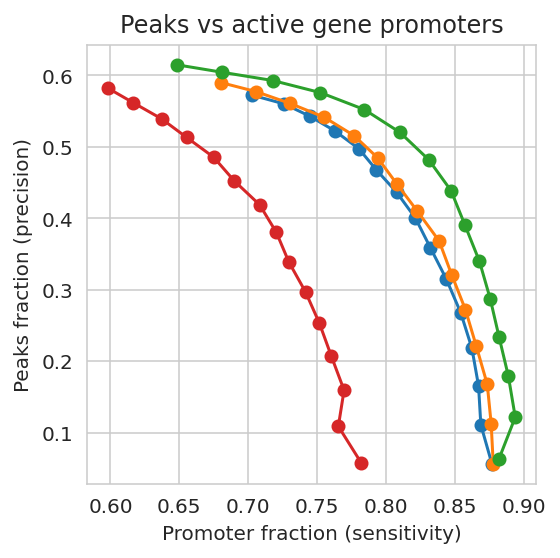

In [41]:
plt.figure(figsize=(4, 4))
for t in ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']:
    tt = benchmark_cpf_df[(benchmark_cpf_df['cell'] == 'Monocyte') &
                          (benchmark_cpf_df['tool'] == t)]
    plt.plot(tt['precision'], tt['sensitivity'], marker='o', label=t)
plt.title('Peaks vs active gene promoters')
plt.xlabel('Promoter fraction (sensitivity)')
plt.ylabel('Peaks fraction (precision)')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_promoters.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Average precision

AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:

AP = ∑(Rn−Rn−1)*Pn, where  Pn and Rn are the precision and recall at the nth threshold.

This implementation is not interpolated and is different from computing the area under the precision-recall curve with the trapezoidal rule, which uses linear interpolation and can be too optimistic.

In [42]:
cells = []
tools = []
aps = []
for c, t in tqdm(product(IMMUNE_CELLS, set(df_fdr_peaks['tool']))):
    dft = benchmark_cpf_df[(benchmark_cpf_df['cell'] == c) &
                           (benchmark_cpf_df['tool'] == t)].copy()
    if len(dft) == 0:
        continue
    ap = 0
    rprev = 0
    for _, row in dft.iterrows():
        ap += (row['sensitivity'] - rprev)*row['precision']
        rprev = row['sensitivity']
    cells.append(c)
    tools.append(t)
    aps.append(ap)
aps_df = pd.DataFrame(dict(cell=cells, tool=tools, ap=aps))

0it [00:00, ?it/s]

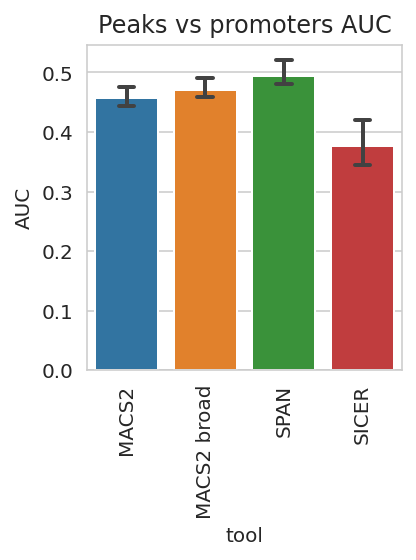

In [43]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
ax.title.set_text('Peaks vs promoters AUC')
g_results = sns.barplot(data=aps_df, x='tool', y='ap',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad',  'SPAN', 'SICER']
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('AUC')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_auc.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Functional annotations

In [44]:
import tempfile

tf = tempfile.mktemp()

! rm -r {PATH}/summary_H3K4me3
! mkdir -p {PATH}/summary_H3K4me3

for c in tqdm(IMMUNE_CELLS):
    print(c)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        filename = tool.replace(' ', '_')
        ! cat {peaks_file} >> "{PATH}/summary_H3K4me3/{filename}.bed_"
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            filename = name.replace(' ', '_')
            !cat {tf} >> "{PATH}/summary_H3K4me3/{filename}.bed_"

for f in os.listdir(PATH + '/summary_H3K4me3'):
    f_sorted = f[:len(f) - 1]
    ! sort -k1,1 -k2,2n -k3,3n "{PATH}/summary_H3K4me3/{f}" | cut -f1-3 > "{PATH}/summary_H3K4me3/{f_sorted}"
    ! rm "{PATH}/summary_H3K4me3/{f}"

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


# Coverage

In [8]:
# Fraction of reads in peaks
IMMUNE_HG38_PATH_BW = os.path.expanduser('~/data/2023_Immune') + '/bw'


def load_bws(path, m):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        cell = next((cc for cc in IMMUNE_CELLS if cc in f), None)
        if cell and m in f:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), m, cell)
    return df_bws

In [9]:
bws_df = load_bws(IMMUNE_HG38_PATH_BW, 'H3K4me3')
display(bws_df.sample(3))
bws_control_df = load_bws(IMMUNE_HG38_PATH_BW, 'Control')
display(bws_control_df.sample(3))

  0%|          | 0/17 [00:00<?, ?it/s]

file modification      cell
2  /home/jetbrains/data/2023_Immune/bw/Monocyte_H...      H3K4me3  Monocyte
0  /home/jetbrains/data/2023_Immune/bw/BCell_H3K4...      H3K4me3     BCell
1  /home/jetbrains/data/2023_Immune/bw/TCell_H3K4...      H3K4me3     TCell

  0%|          | 0/17 [00:00<?, ?it/s]

file modification      cell
1  /home/jetbrains/data/2023_Immune/bw/Monocyte_C...      Control  Monocyte
2  /home/jetbrains/data/2023_Immune/bw/BCell_Cont...      Control     BCell
0  /home/jetbrains/data/2023_Immune/bw/TCell_Cont...      Control     TCell

In [10]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}
CHROM_SIZES

{'chr1': 248956422,
 'chr2': 242193529,
 'chr3': 198295559,
 'chr4': 190214555,
 'chr5': 181538259,
 'chr6': 170805979,
 'chr7': 159345973,
 'chrX': 156040895,
 'chr8': 145138636,
 'chr9': 138394717,
 'chr11': 135086622,
 'chr10': 133797422,
 'chr12': 133275309,
 'chr13': 114364328,
 'chr14': 107043718,
 'chr15': 101991189,
 'chr16': 90338345,
 'chr17': 83257441,
 'chr18': 80373285,
 'chr20': 64444167,
 'chr19': 58617616,
 'chrY': 57227415,
 'chr22': 50818468,
 'chr21': 46709983,
 'chrM': 16569}

## FRIP

In [11]:
import tempfile
import pyBigWig

tf = tempfile.mktemp()

frip_df = pd.DataFrame(
    columns=['cell', 'bw_file', 'tool', 'peaks_file', 'peaks', 'length',
             'reads_in_peaks', 'all_reads', 'control_reads_in_peaks', 'control_all_reads'],
    dtype=object
)

for c in tqdm(IMMUNE_CELLS):
    print(c)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        if peaks == 0:
            continue
        peaks_len = int(bedl(peaks_file).sum())
        t = bws_df[(bws_df['modification'] == 'H3K4me3') &
                   (bws_df['cell'] == c)]
        if len(t) == 0:
            continue
        bw_file = t['file'].values[0]
        t = bws_control_df[bws_control_df['cell'] == c]
        if len(t) == 0:
            continue
        bw_control_file = t['file'].values[0]

        print(tool, peaks_file, bw_file, bw_control_file)
        t = pd.read_csv(peaks_file, sep='\t', header=None)
        with pyBigWig.open(bw_file) as bw:
            total_coverage = sum(
                bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
            peaks_coverage = sum(bw.stats(chr, start, end, type='sum', exact=True)[0]
                                 for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES)
        with pyBigWig.open(bw_control_file) as bwc:
            control_total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
            control_peaks_coverage = sum(bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                         for chr, start, end in zip(t[0], t[1], t[2]))
        frip_df.loc[len(frip_df)] = (c, bw_file, tool, peaks_file, peaks, peaks_len,
                                     peaks_coverage, total_coverage, control_peaks_coverage, control_total_coverage)
frip_df

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
MACS2 /tmp/tmp7fjqsxz1 /home/jetbrains/data/2023_Immune/bw/BCell_H3K4me3_hg38_ENCFF213VRU.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
SICER /tmp/tmpxer8h3k2 /home/jetbrains/data/2023_Immune/bw/BCell_H3K4me3_hg38_ENCFF213VRU.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
MACS2 broad /tmp/tmpko_ja_7p /home/jetbrains/data/2023_Immune/bw/BCell_H3K4me3_hg38_ENCFF213VRU.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
SPAN /tmp/tmppmid_dsx /home/jetbrains/data/2023_Immune/bw/BCell_H3K4me3_hg38_ENCFF213VRU.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
TCell
MACS2 /tmp/tmpueq1y3ro /home/jetbrains/data/2023_Immune/bw/TCell_H3K4me3_hg38_ENCFF661HCG.bw /home/jetbrains/data/2023_Immune/bw/TCell_Control_hg38_ENCFF566HDE.bw
SICER /tmp/tmp6141i3bp /home/jetbrains/data/2023_Immune/bw/TCell_H3K4me3_hg38_ENCFF661HCG.bw /home/jetbrains/data/2023_Immune/bw/TCell_Control_hg38_ENCFF566HDE.bw
MACS2

cell                                            bw_file         tool  \
0      BCell  /home/jetbrains/data/2023_Immune/bw/BCell_H3K4...        MACS2   
1      BCell  /home/jetbrains/data/2023_Immune/bw/BCell_H3K4...        SICER   
2      BCell  /home/jetbrains/data/2023_Immune/bw/BCell_H3K4...  MACS2 broad   
3      BCell  /home/jetbrains/data/2023_Immune/bw/BCell_H3K4...         SPAN   
4      TCell  /home/jetbrains/data/2023_Immune/bw/TCell_H3K4...        MACS2   
5      TCell  /home/jetbrains/data/2023_Immune/bw/TCell_H3K4...        SICER   
6      TCell  /home/jetbrains/data/2023_Immune/bw/TCell_H3K4...  MACS2 broad   
7      TCell  /home/jetbrains/data/2023_Immune/bw/TCell_H3K4...         SPAN   
8   Monocyte  /home/jetbrains/data/2023_Immune/bw/Monocyte_H...        MACS2   
9   Monocyte  /home/jetbrains/data/2023_Immune/bw/Monocyte_H...        SICER   
10  Monocyte  /home/jetbrains/data/2023_Immune/bw/Monocyte_H...  MACS2 broad   
11  Monocyte  /home/jetbrains/data/2023_Immune/bw/Monocyte_H...         SPAN   

          peaks_file  peaks    length  reads_in_peaks     all_reads  \
0   /tmp/tmp7fjqsxz1  26066  27199758    2.702623e+07  8.489444e+07   
1   /tmp/tmpxer8h3k2  18342  48082858    2.868116e+07  8.489444e+07   
2   /tmp/tmpko_ja_7p  24118  28781483    2.726469e+07  8.489444e+07   
3   /tmp/tmppmid_dsx  21067  28873968    2.710656e+07  8.489444e+07   
4   /tmp/tmpueq1y3ro  31242  33096533    3.486846e+07  8.489682e+07   
5   /tmp/tmp6141i3bp  21785  53215015    3.656636e+07  8.489682e+07   
6   /tmp/tmp5_x3l9io  28929  35746467    3.523716e+07  8.489682e+07   
7   /tmp/tmpxmleavlx  25006  37976697    3.533556e+07  8.489682e+07   
8   /tmp/tmpe8z9qkbp  26555  26469058    3.733007e+07  8.489773e+07   
9   /tmp/tmpj1qr2u20  19955  40911445    3.893565e+07  8.489773e+07   
10  /tmp/tmp759soqxi  24096  27671629    3.756001e+07  8.489773e+07   
11  /tmp/tmpfs_0dgk9  23059  31277416    3.793590e+07  8.489773e+07   

    control_reads_in_peaks  control_all_reads  
0             9.594927e+05       8.483952e+07  
1             1.803286e+06       8.481521e+07  
2             1.015575e+06       8.483952e+07  
3             1.059774e+06       8.489085e+07  
4             1.161470e+06       8.485019e+07  
5             1.945063e+06       8.482415e+07  
6             1.257078e+06       8.485019e+07  
7             1.370846e+06       8.490275e+07  
8             1.078223e+06       8.481617e+07  
9             1.691215e+06       8.478965e+07  
10            1.119378e+06       8.481617e+07  
11            1.300871e+06       8.484138e+07

In [12]:
frip_df['frip'] = [d(x, y) for x, y in zip(frip_df['reads_in_peaks'], frip_df['all_reads'])]
frip_df['peaks_rpkm'] = [(x / (z / 1e3)) / (y / 1e6) for x, y, z in zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])]
frip_df['peaks_background_log2fc'] = [
    np.log2((x / z) / ((y - x) / (sum(CHROM_SIZES.values()) - z)))
    for x, y, z in zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])
]
frip_df['peaks_control_log2fc'] = [
    np.log2(d(x / (y / 1e6), z / (u / 1e6)))
    for x, y, z, u in zip(frip_df['reads_in_peaks'], frip_df['all_reads'],
                          frip_df['control_reads_in_peaks'], frip_df['control_all_reads'])
]

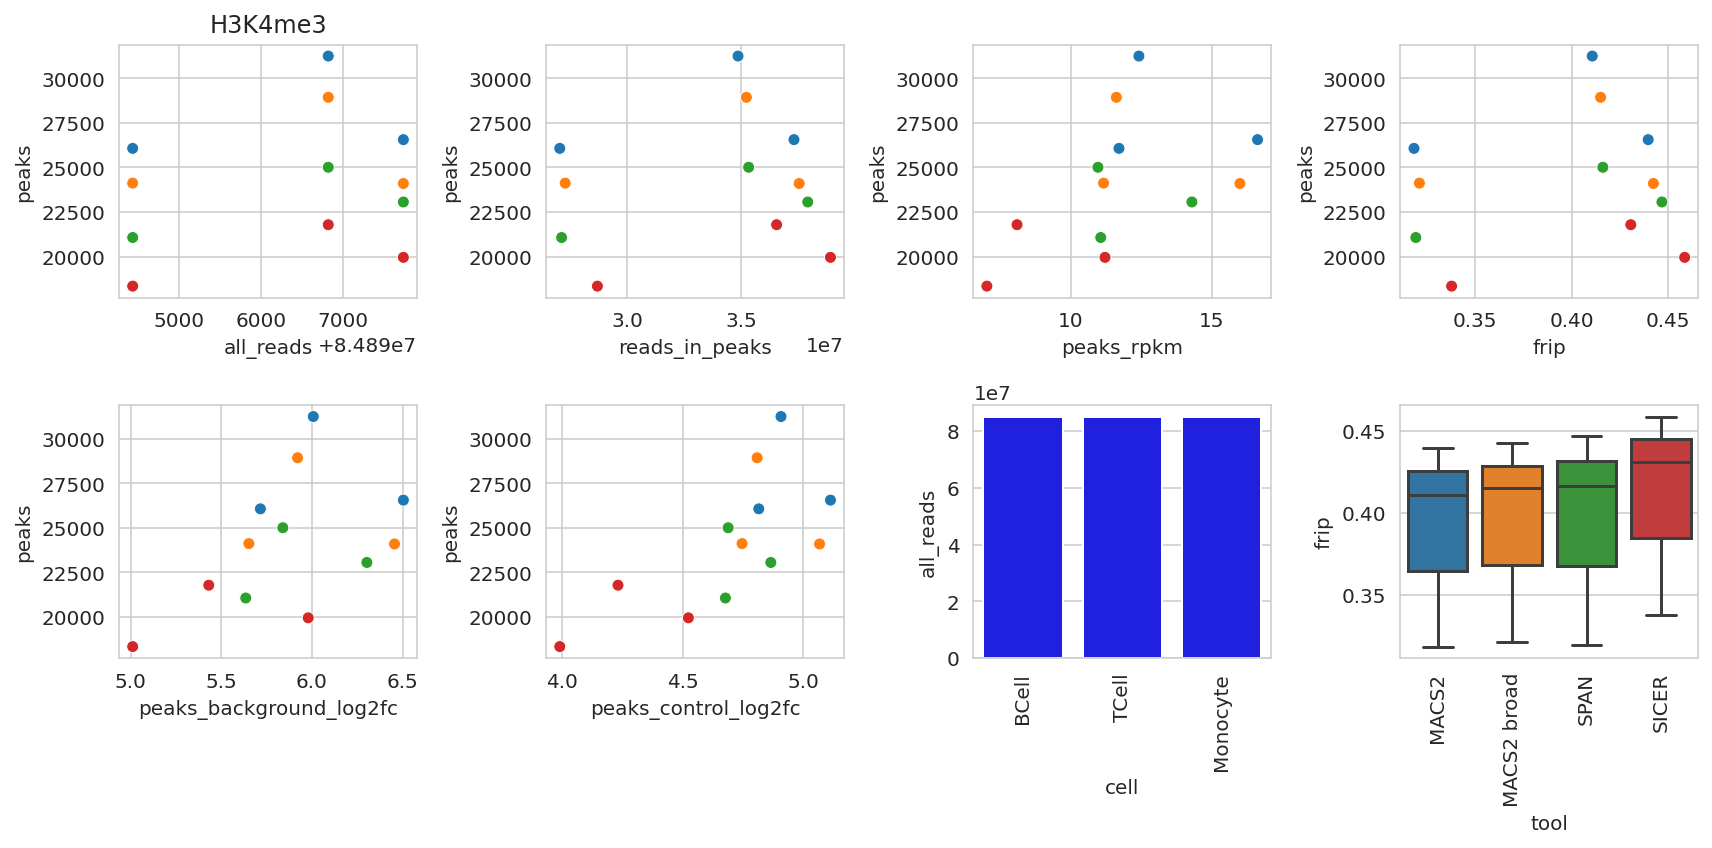

In [13]:
import seaborn as sns

t = frip_df
plt.figure(figsize=(12, 6))
axs = [plt.subplot(2, 4, i + 1) for i in range(8)]
ax = axs[0]
ax.set_title('H3K4me3')
g_results = sns.scatterplot(data=t, x='all_reads', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[1]
g_results = sns.scatterplot(data=t, x='reads_in_peaks', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[2]
g_results = sns.scatterplot(data=t, x='peaks_rpkm', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[3]
g_results = sns.scatterplot(data=t, x='frip', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[4]
g_results = sns.scatterplot(data=t, x='peaks_background_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[5]
g_results = sns.scatterplot(data=t, x='peaks_control_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[6]
tt = t[t['tool'] == 'SPAN']
g_results = sns.barplot(x=tt['cell'], y=tt['all_reads'],
                        color='Blue',
                        # order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)


ax = axs[7]
g_results = sns.boxplot(data=t, x='tool', y='frip',
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False,
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)
# Put a legend to the right of the current axis
# g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig(f'{PATH}/pics/H3K4me3_reads.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [14]:
frip_df.to_csv(f'{PATH}/pics/H3K4me3_frip.csv.gz', index=None, compression='gzip')

## Peaks Density

In [13]:
import pyBigWig
import tempfile
from itertools import product

tf = tempfile.mktemp()

coverage_data = []

for c in tqdm(IMMUNE_CELLS):
    print(c)
    t = bws_df[(bws_df['modification'] == 'H3K4me3') &
               (bws_df['cell'] == c)]
    if len(t) == 0:
        continue
    bw_file = t['file'].values[0]
    t = bws_control_df[bws_control_df['cell'] == c]
    if len(t) == 0:
        continue
    bw_control_file = t['file'].values[0]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        if lines(peaks_file) > 0:
            t = pd.read_csv(peaks_file, sep='\t', header=None)
            positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            with pyBigWig.open(bw_file) as bw:
                total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                     for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K4me3', c, tool, pos, length, 'treatment', peak_coverage, total_coverage))
            with pyBigWig.open(bw_control_file) as bwc:
                total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                             for chr, start, end in zip(t[0], t[1], t[2])]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K4me3', c, tool, pos, length, 'control', peak_coverage, total_coverage))
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            if lines(tf) > 0:
                t = pd.read_csv(tf, sep='\t', header=None)
                positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                with pyBigWig.open(bw_file) as bw:
                    total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                    peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                        for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K4me3', c, name, pos, length, 'treatment', peak_coverage, total_coverage))
                with pyBigWig.open(bw_control_file) as bwc:
                    total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                    peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2])]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K4me3', c, name, pos, length, 'control', peak_coverage, total_coverage))

df_coverage = pd.DataFrame(
    coverage_data,
    columns=['modification', 'cell', 'name', 'position', 'length', 'type', 'coverage', 'total_coverage']
)
del coverage_data
df_coverage.sample(5)

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


modification      cell         name                position  length  \
557063      H3K4me3  Monocyte  MACS2 broad   chr10:6144966-6146358    1392   
531741      H3K4me3  Monocyte         SPAN  chr1:12376201-12376786     585   
472534      H3K4me3  Monocyte        SICER   chr12:3869800-3873999    4199   
549621      H3K4me3  Monocyte         SPAN    chr6:7260719-7261991    1272   
252392      H3K4me3     TCell        SICER  chr1:46442400-46443399     999   

             type     coverage  total_coverage  
557063  treatment  1382.517308    8.489773e+07  
531741    control    19.932489    8.484138e+07  
472534  treatment  2772.950687    8.489773e+07  
549621    control    46.243412    8.484138e+07  
252392  treatment   299.131593    8.489682e+07

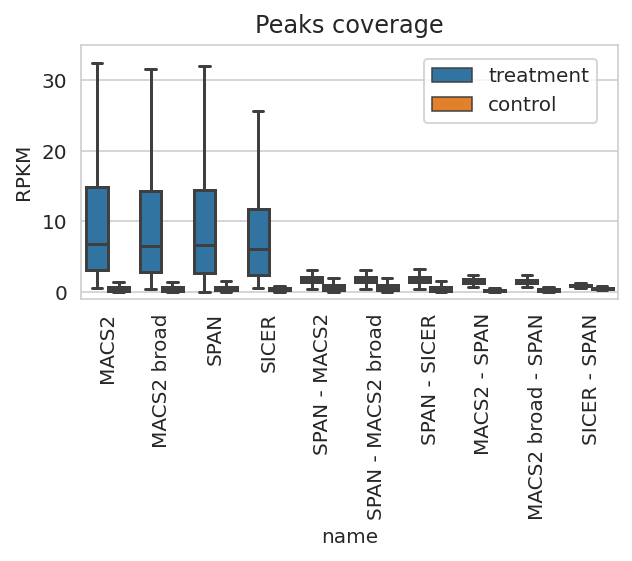

In [14]:
df_coverage['rpm'] = df_coverage['coverage'] / (df_coverage['total_coverage'] / 1e6)
df_coverage['rpkm'] = df_coverage['rpm'] / (df_coverage['length'] / 1e3)

plt.figure(figsize=(4.5, 4))
g_results = sns.boxplot(data=df_coverage, x='name', y='rpkm', hue='type', showfliers = False,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax = g_results.axes
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('RPKM')
ax.set_ylim(-1, 35)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(0.62, 0.82))
plt.title('Peaks coverage')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_coverage.pdf', bbox_inches='tight', dpi=300)
plt.show()

# ChromHMM

In [53]:
CHROMHMM_MAP = {
    'BCell': PATH + '/chromhmm/BCell_Chromhmm_hg38_ENCFF885QXH.bed',
    'TCell': PATH + '/chromhmm/TCell_Chromhmm_hg38_ENCFF037LJR.bed',
    'Monocyte': PATH + '/chromhmm/Monocyte_Chromhmm_hg38_ENCFF560DUU.bed',
}

In [54]:
print('Split chromHMM into separate files')
CHROMM_STATES = set()
for c, chromhmm in CHROMHMM_MAP.items():
    print(c)
    t = pd.read_csv(chromhmm, sep='\t', header=None, usecols=[3])[3]
    for state in t.unique():
        # print(state)
        state = state.replace('/', '_')
        CHROMM_STATES.add(state)
        f = chromhmm.replace('.bed', f'_{state}.bed')
        ! cat {chromhmm} | grep {state} > {f}

CHROMM_STATES = list(sorted(CHROMM_STATES))
print(CHROMM_STATES)

Split chromHMM into separate files
BCell
TCell
Monocyte
['EnhA1', 'EnhA2', 'EnhBiv', 'EnhG1', 'EnhG2', 'EnhWk', 'Het', 'Quies', 'ReprPC', 'ReprPCWk', 'TssA', 'TssBiv', 'TssFlnk', 'TssFlnkD', 'TssFlnkU', 'Tx', 'TxWk', 'ZNF_Rpts']


In [55]:
import tempfile

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

data = []

for c in tqdm(IMMUNE_CELLS):
    print(c)
    if c not in CHROMHMM_MAP:
        continue
    chromhmm = CHROMHMM_MAP[c]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        row = [c, tool, peaks]
        for state in CHROMM_STATES:
            state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
            !bedtools intersect -a {peaks_file} -b {state_file} -wa -u > {tf}
            state_peaks = lines(tf)
            row.append(state_peaks)
        data.append(row)

        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            ! bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            row = [c, name, peaks]
            for state in CHROMM_STATES:
                state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
                !bedtools intersect -a {tf} -b {state_file} -wa -u > {tf2}
                state_peaks = lines(tf2)
                row.append(state_peaks)
            data.append(row)

chromhmm_df = pd.DataFrame(data, columns=['cell', 'name', 'peaks'] + CHROMM_STATES)
chromhmm_df

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


cell                name  peaks  EnhA1  EnhA2  EnhBiv  EnhG1  EnhG2  \
0      BCell               SICER  18342   7236   1071    3356    931    831   
1      BCell         MACS2 broad  24118   6322    534    3246    193    722   
2      BCell               MACS2  26066   5502    489    3029    138    714   
3      BCell                SPAN  21067   5438    436    2069    135    647   
4      BCell        SPAN - MACS2   1189    699     27      75      7     43   
5      BCell        MACS2 - SPAN    419     74      6     154      4      8   
6      BCell  SPAN - MACS2 broad    815    462     17      50      5     26   
7      BCell  MACS2 broad - SPAN    823    215     17     244     12     30   
8      BCell        SPAN - SICER   1750    491     27     279      6     32   
9      BCell        SICER - SPAN    184    146     32      14     17     32   
10     TCell               SICER  21785  10293   1129    4525    921   1414   
11     TCell         MACS2 broad  28929   9698    645    4436    219   1431   
12     TCell               MACS2  31242   8001    585    3992    142   1384   
13     TCell                SPAN  25006   8818    565    3424    245   1296   
14     TCell        SPAN - MACS2   2111   1151     57     228     26    150   
15     TCell        MACS2 - SPAN    205     49      3      81      2      6   
16     TCell  SPAN - MACS2 broad   1214    656     30     120     13     84   
17     TCell  MACS2 broad - SPAN    620    215     11     191      6     26   
18     TCell        SPAN - SICER   2063    624     52     446     13     52   
19     TCell        SICER - SPAN    190    149     11       8     12     26   
20  Monocyte               SICER  19955   9247   1203    4103    669    911   
21  Monocyte         MACS2 broad  24096   6185    914    2944     96    790   
22  Monocyte               MACS2  26555   5555    872    2715     64    785   
23  Monocyte                SPAN  23059   8096    790    3279    185    855   
24  Monocyte        SPAN - MACS2   3052   1619     47     428     22    113   
25  Monocyte        MACS2 - SPAN      6      2      0       0      0      0   
26  Monocyte  SPAN - MACS2 broad   2562   1387     37     348     19     96   
27  Monocyte  MACS2 broad - SPAN     24      7      1       3      1      0   
28  Monocyte        SPAN - SICER   2115    845     38     339     11     52   
29  Monocyte        SICER - SPAN     72     61      2       7      3      8   

    EnhWk  Het  ...  ReprPC  ReprPCWk   TssA  TssBiv  TssFlnk  TssFlnkD  \
0   12049  149  ...    2584      1605   8557    3209    15010      9441   
1    7604   38  ...     610       311   9031    4115    18259     10424   
2    6854   30  ...     553       280   9611    4422    20232     10874   
3    5431   17  ...     347       187   8666    3591    16220      9898   
4     161    2  ...      19        14      2      30      292       161   
5      79    8  ...      19        12      2      78       90        65   
6     108    2  ...      13        10      0      17      169       115   
7     179   11  ...      31        18      3     121      181       127   
8     238    4  ...      60        38      5     256      540       336   
9      82    1  ...      10         7      0       3       11         8   
10  11057   41  ...    2994      1908   8546    4747    16700      8705   
11   7121   24  ...    1192       604   8922    5873    20281      9470   
12   5980   19  ...    1008       497   9517    6405    22819      9821   
13   6208   16  ...     838       446   8612    5184    17745      9019   
14    308    1  ...      64        38      4      94      406       201   
15     16    0  ...      11         4      0      30       27        17   
16    170    1  ...      35        18      3      44      166       100   
17     86    2  ...      45        25      0      60       75        49   
18    283    5  ...     132        77      8     252      408       252   
19     56    0  ...       5         4      0       3      

In [56]:
# Split by cell
# for c in tqdm(IMMUNE_CELLS):
#     print(c)
#     t = chromhmm_df[chromhmm_df['cell']==c].copy()
#     if len(t) == 0:
#         continue
#     t.index = t['name']
#     plt.figure(figsize=(8, 3))
#     sns.heatmap(t[CHROMM_STATES].loc[['MACS2', 'MACS2 broad', 'SICER', 'SPAN',
#                                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
#                                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
#                                       ]], cmap='coolwarm')
#     plt.show()

In [57]:
chrommm_df_mean = chromhmm_df[['name'] + CHROMM_STATES].groupby('name').mean()
chrommm_df_mean = chrommm_df_mean.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                       ]]
chrommm_df_mean

EnhA1        EnhA2       EnhBiv       EnhG1  \
name                                                                    
MACS2               6352.666667   648.666667  3245.333333  114.666667   
MACS2 broad         7401.666667   697.666667  3542.000000  169.333333   
SPAN                7450.666667   597.000000  2924.000000  188.333333   
SICER               8925.333333  1134.333333  3994.666667  840.333333   
SPAN - MACS2        1156.333333    43.666667   243.666667   18.333333   
SPAN - MACS2 broad   835.000000    28.000000   172.666667   12.333333   
SPAN - SICER         653.333333    39.000000   354.666667   10.000000   
MACS2 - SPAN          41.666667     3.000000    78.333333    2.000000   
MACS2 broad - SPAN   145.666667     9.666667   146.000000    6.333333   
SICER - SPAN         118.666667    15.000000     9.666667   10.666667   

                          EnhG2         EnhWk        Het        Quies  \
name                                                                    
MACS2                961.000000   5782.666667  21.000000   959.000000   
MACS2 broad          981.000000   6563.333333  27.000000  1020.333333   
SPAN                 932.666667   5773.333333  17.666667   859.666667   
SICER               1052.000000  11250.333333  75.333333  2542.666667   
SPAN - MACS2         102.000000    342.333333   2.333333   113.333333   
SPAN - MACS2 broad    68.666667    249.666667   2.000000    90.000000   
SPAN - SICER          45.333333    309.000000   5.000000   160.333333   
MACS2 - SPAN           4.666667     31.666667   2.666667    11.333333   
MACS2 broad - SPAN    18.666667     89.666667   4.333333    27.333333   
SICER - SPAN          22.000000     56.666667   0.333333     7.000000   

                         ReprPC     ReprPCWk          TssA       TssBiv  \
name                                                                      
MACS2                655.333333   293.333333  10306.666667  5436.000000   
MACS2 broad          745.666667   343.000000   9506.000000  5003.000000   
SPAN                 526.666667   247.000000   8985.666667  4425.000000   
SICER               2352.333333  1321.333333   8876.333333  4045.666667   
SPAN - MACS2          44.333333    22.333333      4.333333   101.666667   
SPAN - MACS2 broad    30.666667    14.000000      2.000000    62.666667   
SPAN - SICER          79.333333    42.666667      6.666667   217.666667   
MACS2 - SPAN          10.333333     5.666667      0.666667    36.000000   
MACS2 broad - SPAN    25.666667    14.666667      1.000000    60.333333   
SICER - SPAN           6.000000     3.666667      0.000000     2.333333   

                         TssFlnk     TssFlnkD      TssFlnkU           Tx  \
name                                                                       
MACS2               21046.000000  8745.000000  16269.333333   289.333333   
MACS2 broad         18911.666667  8459.666667  14873.666667   318.000000   
SPAN                16771.000000  8220.333333  13498.333333   256.000000   
SICER               15679.666667  7852.333333  12933.666667  1869.333333   
SPAN - MACS2          483.666667   257.666667    206.666667    20.333333   
SPAN - MACS2 broad    295.000000   186.000000     91.333333    14.666667   
SPAN - SICER          483.000000   310.000000    127.000000    23.333333   
MACS2 - SPAN           40.000000    27.666667      9.000000     4.000000   
MACS2 broad - SPAN     87.333333    60.000000     20.666667     7.333333   
SICER - SPAN            7.333333     6.000000      1.000000    12.000000   

                           TxWk  ZNF_Rpts  
name                                       
MACS2                287.333333       0.0  
MACS2 broad          315.333333       0.0  
SPAN                 252.000000       0.0  
SICER               1769.333333       0.0  
SPAN - MACS2          19.000000       0.0  
SPAN - MACS2 broad    13.333333       0.0  
SPAN - SICER          22.333333       0.0  
MACS2 - SPAN           3.666667       0.0  
MACS2 broad - SPAN

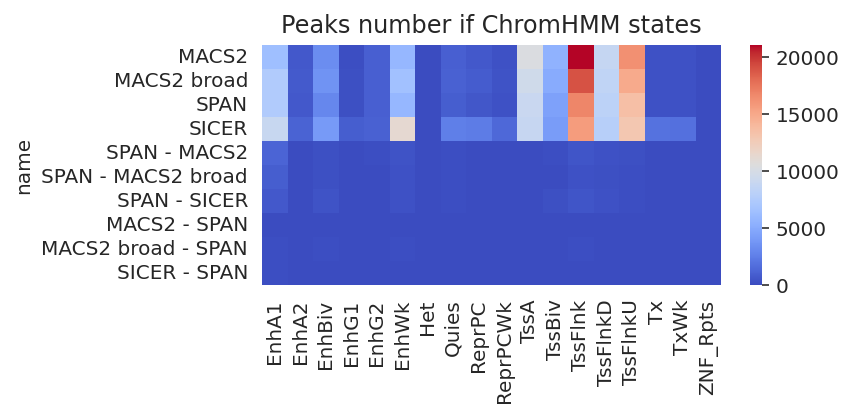

In [58]:
plt.figure(figsize=(6, 3))
sns.heatmap(chrommm_df_mean, cmap='coolwarm')
plt.title('Peaks number if ChromHMM states')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_chromhmm.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [59]:
chromhmm_rel_df = chromhmm_df[['name']].copy()
for state in CHROMM_STATES:
    chromhmm_rel_df[state] = [d(ov, p) for ov, p in zip(chromhmm_df[state], chromhmm_df['peaks'])]
chromhmm_rel_df_mean = chromhmm_rel_df[['name'] + CHROMM_STATES].groupby('name').mean()
chromhmm_rel_df_mean = chromhmm_rel_df_mean.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                                 'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                                 'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                                 ]]
chromhmm_rel_df_mean

EnhA1     EnhA2    EnhBiv     EnhG1     EnhG2  \
name                                                                   
MACS2               0.225455  0.023441  0.115407  0.004083  0.033751   
MACS2 broad         0.284681  0.027456  0.136702  0.006519  0.037396   
SPAN                0.320621  0.025850  0.125779  0.008076  0.039873   
SICER               0.443459  0.056834  0.198764  0.042187  0.051955   
SPAN - MACS2        0.554533  0.021703  0.103773  0.008471  0.048082   
SPAN - MACS2 broad  0.549536  0.020004  0.098676  0.008086  0.046188   
SPAN - SICER        0.327524  0.019534  0.178634  0.004977  0.022693   
MACS2 - SPAN        0.249656  0.009651  0.254221  0.006434  0.016120   
MACS2 broad - SPAN  0.299893  0.026688  0.243180  0.021975  0.026129   
SICER - SPAN        0.808304  0.086529  0.071805  0.065739  0.140622   

                       EnhWk       Het     Quies    ReprPC  ReprPCWk  \
name                                                                   
MACS2               0.208115  0.000762  0.034498  0.022910  0.010176   
MACS2 broad         0.255829  0.001065  0.039869  0.028183  0.012835   
SPAN                0.250808  0.000771  0.037262  0.022371  0.010465   
SICER               0.565970  0.003937  0.128560  0.117477  0.065896   
SPAN - MACS2        0.154714  0.001155  0.054982  0.020893  0.011563   
SPAN - MACS2 broad  0.152130  0.001483  0.063689  0.020652  0.010854   
SPAN - SICER        0.155047  0.002515  0.081379  0.040007  0.021728   
MACS2 - SPAN        0.088864  0.006364  0.090113  0.088557  0.071606   
MACS2 broad - SPAN  0.174291  0.005531  0.078305  0.050638  0.034620   
SICER - SPAN        0.394944  0.001812  0.043222  0.040777  0.019699   

                        TssA    TssBiv   TssFlnk  TssFlnkD  TssFlnkU  \
name                                                                   
MACS2               0.372466  0.193687  0.754336  0.313383  0.582899   
MACS2 broad         0.373772  0.194003  0.737745  0.329064  0.580228   
SPAN                0.391834  0.190973  0.729506  0.359869  0.585741   
SICER               0.445396  0.200792  0.784367  0.395156  0.645759   
SPAN - MACS2        0.001957  0.043022  0.228211  0.121763  0.097232   
SPAN - MACS2 broad  0.001214  0.035558  0.186259  0.119119  0.054586   
SPAN - SICER        0.003348  0.112332  0.247740  0.158618  0.065254   
MACS2 - SPAN        0.001591  0.110833  0.282168  0.134908  0.081223   
MACS2 broad - SPAN  0.001215  0.081266  0.196965  0.133337  0.041115   
SICER - SPAN        0.000000  0.015328  0.042101  0.034912  0.005378   

                          Tx      TxWk  ZNF_Rpts  
name                                              
MACS2               0.010437  0.010363       0.0  
MACS2 broad         0.012437  0.012334       0.0  
SPAN                0.011082  0.010912       0.0  
SICER               0.095126  0.090073       0.0  
SPAN - MACS2        0.009175  0.008640       0.0  
SPAN - MACS2 broad  0.009286  0.008477       0.0  
SPAN - SICER        0.011493  0.010984       0.0  
MACS2 - SPAN        0.012868  0.012073       0.0  
MACS2 broad - SPAN  0.010104  0.009161       0.0  
SICER - SPAN        0.073099  0.058778       0.0

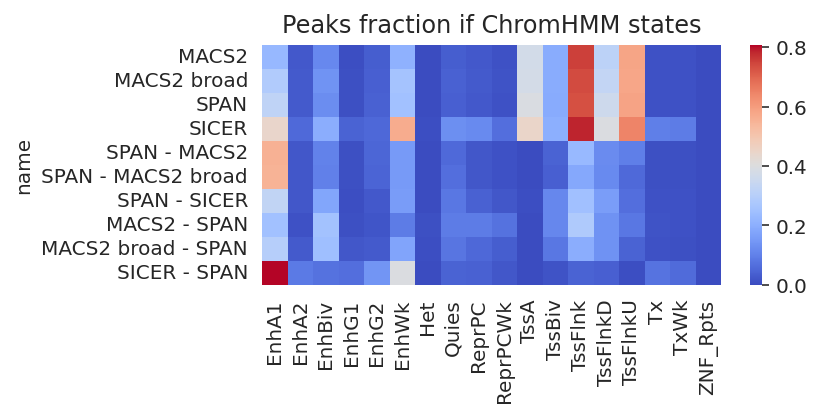

In [60]:
plt.figure(figsize=(6, 3))
sns.heatmap(chromhmm_rel_df_mean, cmap='coolwarm')
plt.title('Peaks fraction if ChromHMM states')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_chromhmm_rel.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Split by ChromHMM state and lengths distributions

In [61]:
tf = tempfile.mktemp()
BED_CHROMHMM = PATH + '/bed_chromhmm'

!mkdir -p {BED_CHROMHMM}

print('Load lengths')
ts = []
for c in tqdm(IMMUNE_CELLS):
    print(c)
    if c not in CHROMHMM_MAP:
        continue
    chromhmm = CHROMHMM_MAP[c]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        print(tool)
        peaks_file = sorted_file(t['file'].values[0])
        for state in CHROMM_STATES:
            state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
            path = f"{BED_CHROMHMM}/{c}_{tool}_{state}.bed".replace(' ', '_')
            !bedtools intersect -a {peaks_file} -b {state_file} -wa -u > {path}
            print(path)
            lengths = bedl(path)
            t = pd.DataFrame(dict(length=lengths))
            t = t.sample(min(len(t), 10_000))
            t['state'] = state
            t['name'] = tool
            ts.append(t)

        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            print(name)
            diff = f"{BED_CHROMHMM}/{c}_{name}.bed".replace(' ', '_').replace('_-_', '_')
            !bedtools intersect {args} -wa -v > {diff}
            for state in CHROMM_STATES:
                state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
                path = f"{BED_CHROMHMM}/{c}_{name}_{state}.bed".replace(' ', '_').replace('_-_', '_')
                !bedtools intersect -a {diff} -b {state_file} -wa -u > {path}
                print(path)
                lengths = bedl(path)
                t = pd.DataFrame(dict(length=lengths))
                t = t.sample(min(len(t), 10_000))
                t['state'] = state
                t['name'] = name
                ts.append(t)

t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


  0%|          | 0/3 [00:00<?, ?it/s]

BCell
SICER
/home/jetbrains/data/2023_Immune/bed_chromhmm/BCell_SICER_EnhA1.bed
/home/jetbrains/data/2023_Immune/bed_chromhmm/BCell_SICER_EnhA2.bed
/home/jetbrains/data/2023_Immune/bed_chromhmm/BCell_SICER_EnhBiv.bed
/home/jetbrains/data/2023_Immune/bed_chromhmm/BCell_SICER_EnhG1.bed
/home/jetbrains/data/2023_Immune/bed_chromhmm/BCell_SICER_EnhG2.bed
/home/jetbrains/data/2023_Immune/bed_chromhmm/BCell_SICER_EnhWk.bed
/home/jetbrains/data/2023_Immune/bed_chromhmm/BCell_SICER_Het.bed
/home/jetbrains/data/2023_Immune/bed_chromhmm/BCell_SICER_Quies.bed
/home/jetbrains/data/2023_Immune/bed_chromhmm/BCell_SICER_ReprPC.bed
/home/jetbrains/data/2023_Immune/bed_chromhmm/BCell_SICER_ReprPCWk.bed
/home/jetbrains/data/2023_Immune/bed_chromhmm/BCell_SICER_TssA.bed
/home/jetbrains/data/2023_Immune/bed_chromhmm/BCell_SICER_TssBiv.bed
/home/jetbrains/data/2023_Immune/bed_chromhmm/BCell_SICER_TssFlnk.bed
/home/jetbrains/data/2023_Immune/bed_chromhmm/BCell_SICER_TssFlnkD.bed
/home/jetbrains/data/2023_Im

length     state          name
647458  2561.0    EnhBiv   MACS2 broad
469622   477.0   TssFlnk         MACS2
301681  1599.0    ReprPC         SICER
317990  5799.0    TssBiv         SICER
367160  1181.0     EnhWk   MACS2 broad
253528  1765.0  TssFlnkU          SPAN
326652  1799.0   TssFlnk         SICER
163348  2312.0      TssA         MACS2
353802  1387.0     EnhA1   MACS2 broad
819860   178.0  TssFlnkU  SPAN - MACS2

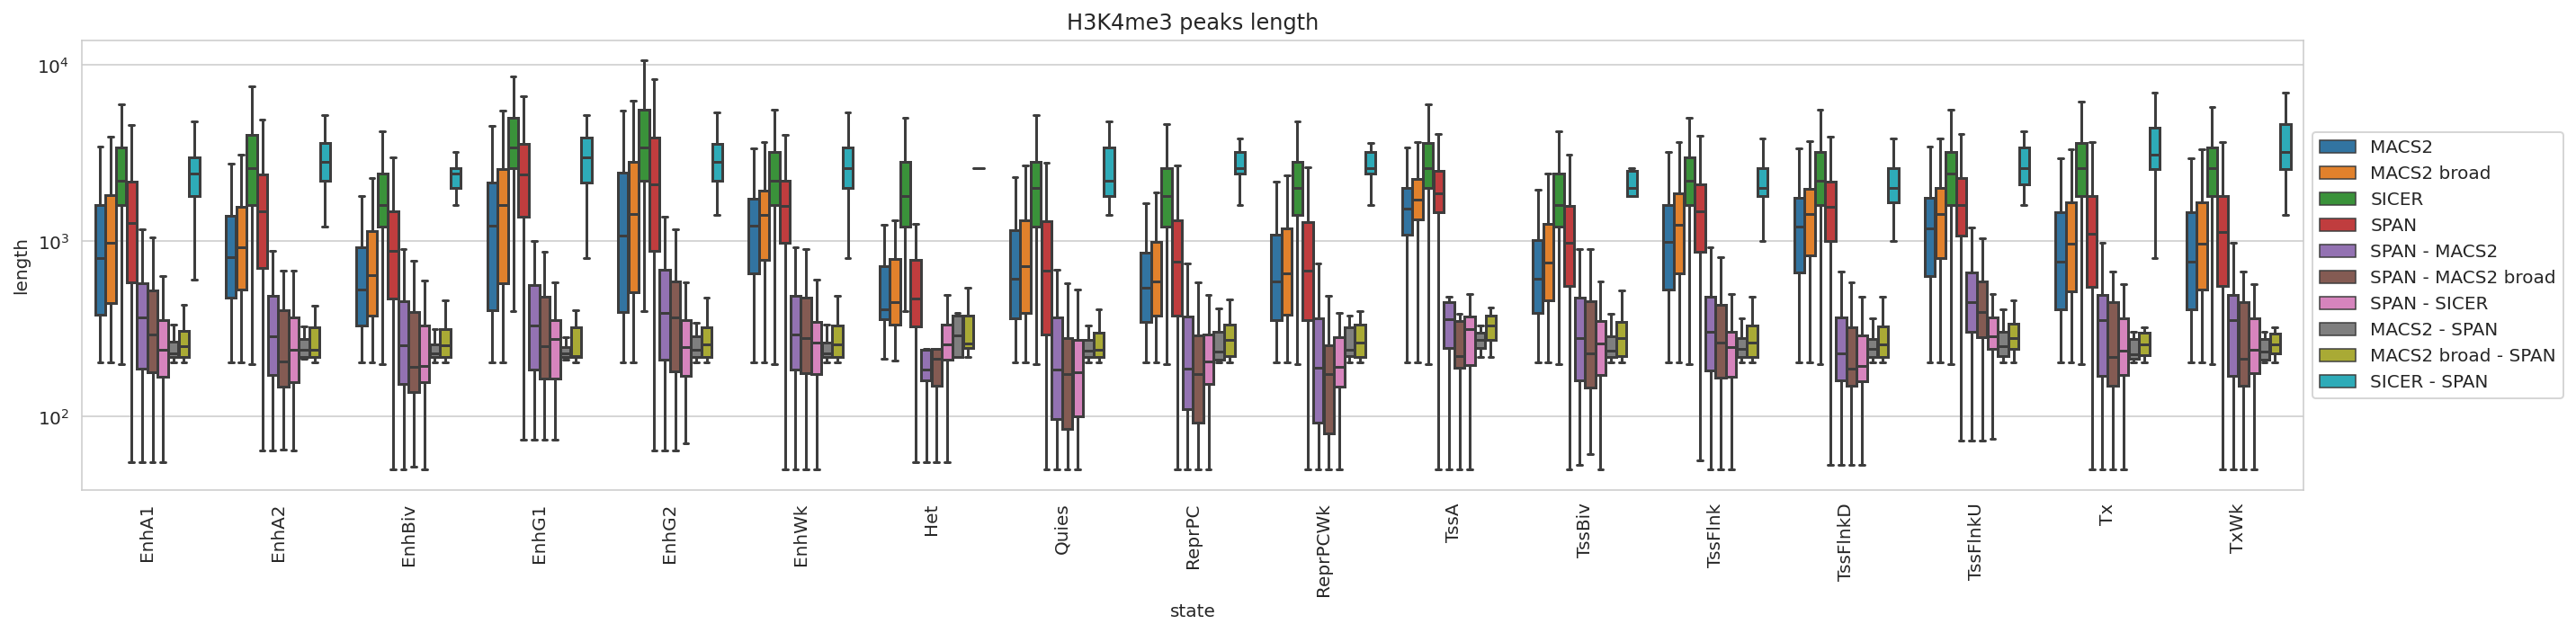

In [62]:
plt.figure(figsize=(20, 5))
ax = plt.axes()
g_results = sns.boxplot(data=t, x='state', y='length', hue='name', ax=ax,  showfliers=False,
                        hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   ])
ax.title.set_text('H3K4me3 peaks length')
ax.xaxis.set_tick_params(rotation=90)
g_results.set(yscale='log')
# ax.set_ylim([0, 15_000])
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()